<a href="https://colab.research.google.com/github/faorjuelal/SAPP---IIND---005786/blob/main/Semana4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

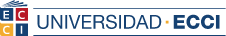
# **SISTEMAS AVANZADOS DE PRODUCCIÓN CON PYTHON**

# **Taller 2 (2h): Fundamentos de Inferencia Estadística e Introducción al Modelado**

**Objetivos de la sesión**

- Comprender y aplicar conceptos estadísticos fundamentales, incluyendo la distribución normal, la varianza, la covarianza y la correlación para describir datos y sus relaciones. 📊

- Implementar técnicas de inferencia estadística para sacar conclusiones sobre una población a partir de una muestra, utilizando el Teorema del Límite Central y el bootstrapping.

- Formular y ejecutar tests de hipótesis, interpretando correctamente el p-valor y comprendiendo la diferencia entre los errores de Tipo I y Tipo II.

- Ajustar modelos de regresión lineal utilizando los enfoques frecuentista (Mínimos Cuadrados Ordinarios) y bayesiano, entendiendo la intuición detrás de cada método.

 -Diagnosticar y evaluar la calidad de un modelo de regresión, analizando los residuos, identificando puntos influyentes y utilizando métricas clave como el R². 📈




# **Sección 1: Fundamentos de Inferencia Estadística**
En esta sección vamos a aprender los conceptos básicos de inferencia estadística de una manera super sencilla.

- ¿Qué es la inferencia estadística?

  Imagina que quieres saber qué piensan TODOS los clientes de una tienda online, pero preguntarles a todos sería imposible (son miles!). La inferencia estadística nos permite sacar conclusiones sobre TODA la población estudiando solo una pequeña PARTE (una muestra).

- Dataset que usaremos: Brazilian E-Commerce (Olist)

**Vamos a trabajar con datos reales de e-commerce de Brasil. Este dataset contiene información sobre:**

  1. Pedidos de clientes

  2. Productos vendidos

  3. Reseñas de clientes

  4. Datos de ubicación

  Los datos se pueden descargar del drive y cargar directamente:

  https://drive.google.com/drive/folders/1bUDf7L95lTN_AiuBHeKCcZlSyZbhX5E0?usp=sharing
  


In [ ]:
# 1) Subir datos desde Drive e importar librerias

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from datetime import datetime
from google.colab import drive





drive.mount('/content/drive')
# Buscamos la ruta del archivo en drive
base = '/content/drive/MyDrive/Colab Notebooks/DatosTaller2/'
orders    = pd.read_csv(base+"olist_orders_dataset.csv",
                        parse_dates=["order_purchase_timestamp","order_approved_at",
                                     "order_delivered_carrier_date","order_delivered_customer_date",
                                     "order_estimated_delivery_date"])
# Asi vamos a llamar a cada una de las listas
items     = pd.read_csv(base+"olist_order_items_dataset.csv", parse_dates=["shipping_limit_date"])
customers = pd.read_csv(base+"olist_customers_dataset.csv")
products  = pd.read_csv(base+"olist_products_dataset.csv")
sellers   = pd.read_csv(base+"olist_sellers_dataset.csv")
payments  = pd.read_csv(base+"olist_order_payments_dataset.csv")
reviews   = pd.read_csv(base+"olist_order_reviews_dataset.csv",
                        parse_dates=["review_creation_date","review_answer_timestamp"])
geoloc    = pd.read_csv(base+"olist_geolocation_dataset.csv")

#Un diccionario que recorra todas las tablas y sus tamaños:
{t: df.shape for t,df in {
    "orders":orders, "items":items, "customers":customers, "products":products,
    "sellers":sellers, "payments":payments, "reviews":reviews, "geolocation":geoloc}.items()}



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


{'orders': (99441, 8),
 'items': (112650, 7),
 'customers': (99441, 5),
 'products': (32951, 9),
 'sellers': (3095, 4),
 'payments': (103886, 5),
 'reviews': (99224, 7),
 'geolocation': (1000163, 5)}

In [ ]:
#Un diccionario que recorra todas las tablas y el tipo de dato de cada columna
{t: df.dtypes for t,df in {
    "orders":orders, "items":items, "customers":customers, "products":products,
    "sellers":sellers, "payments":payments, "reviews":reviews, "geolocation":geoloc}.items()}

{'orders': order_id                                 object
 customer_id                              object
 order_status                             object
 order_purchase_timestamp         datetime64[ns]
 order_approved_at                datetime64[ns]
 order_delivered_carrier_date     datetime64[ns]
 order_delivered_customer_date    datetime64[ns]
 order_estimated_delivery_date    datetime64[ns]
 dtype: object,
 'items': order_id                       object
 order_item_id                   int64
 product_id                     object
 seller_id                      object
 shipping_limit_date    datetime64[ns]
 price                         float64
 freight_value                 float64
 dtype: object,
 'customers': customer_id                 object
 customer_unique_id          object
 customer_zip_code_prefix     int64
 customer_city               object
 customer_state              object
 dtype: object,
 'products': product_id                     object
 product_category_name  

## **1.1 Variables Aleatorias y Distribuciones**

Esta subsección explora los conceptos de variables aleatorias y distribuciones de probabilidad, dedicando una atención especial a la distribución Normal.

### **1.1.1 ¿Qué es una variable aleatoria?**


**Definición (breve).**
Una **variable aleatoria** $X$ es una función que asigna a cada resultado de un experimento aleatorio un número real.

**Interpretación en datos (ejemplo con productos).**
Si el “experimento” es **elegir un producto al azar del catálogo**, entonces:

* $W =$ *peso del producto en gramos* es una **variable aleatoria continua** (toma valores en $\mathbb{R}^+$).
* Cada valor observado $w_i$ en el CSV es una **realización** de $W$.
* La **distribución** de $W$ describe qué pesos son más o menos probables en el catálogo.

> **Nota.** Si quisieras una variable aleatoria **discreta**, podrías usar `product_photos_qty` (número de fotos).


Los datos faltantes son:2
n = 32778
Media (≈ E[W]): 2135.7363780584537
Varianza (≈ Var[W]): 14504153.76236459
Desviación estándar: 3808.431929595774

5 pesos tomados al azar (realizaciones de W):
[ 100. 1350.  700. 1475.  100.]


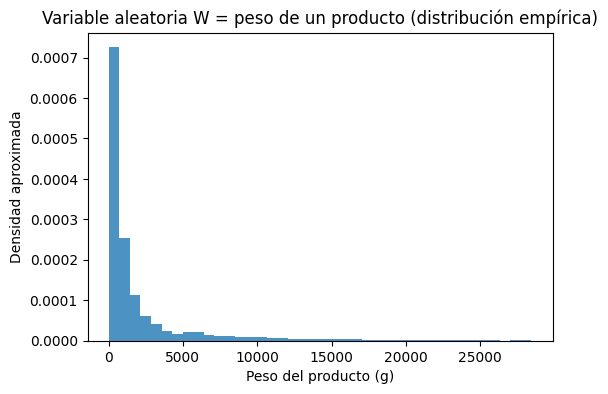

In [ ]:
# --- Reportamos los valores faltantes ---

print("Los datos faltantes son:" + str(products['product_weight_g'].isna().sum()))

# --- Seleccionamos la columna y limpiamos valores faltantes ---
W = products['product_weight_g'].dropna()

# (Opcional) Filtrar valores no positivos o extremos para visualizar mejor
W = W[(W > 0) & (W < W.quantile(0.995))]

# --- Estadísticos básicos: estas son estimaciones de E[W] y Var(W) a partir de la muestra ---
print("n =", W.shape[0])
print("Media (≈ E[W]):", W.mean())
print("Varianza (≈ Var[W]):", W.var(ddof=1))
print("Desviación estándar:", W.std(ddof=1))

# --- Experimento aleatorio: tomar productos al azar y ver sus pesos (realizaciones de W) ---
muestra = W.sample(5, replace=True, random_state=42)
print("\n5 pesos tomados al azar (realizaciones de W):")
print(muestra.values)

# --- Distribución empírica (histograma como aproximación de la densidad) ---
plt.figure(figsize=(6,4))
plt.hist(W, bins=40, density=True, alpha=0.8)
plt.xlabel("Peso del producto (g)")
plt.ylabel("Densidad aproximada")
plt.title("Variable aleatoria W = peso de un producto (distribución empírica)")
plt.show()


Qué ilustra el código:

*   W representa la variable aleatoria “peso de un producto”.

*   W.sample(5) simula cinco resultados del experimento “elegir un producto al azar”.

*   mean/var/std son estimaciones muestrales de los parámetros de la distribución de
W.

*   El histograma es una aproximación empírica de la distribución de probabilidad de
W.

### **1.1.2 Media, Varianza y Desviación Estándar**

# **1.1.2 Media, Varianza y Desviación Estándar Muestrales**

## Contexto

Sea $W$ la variable aleatoria continua "peso del producto (g)". Cada registro del CSV entrega una realización $w_i$ de $W$.

## Objetivo

Estimar los parámetros centrales de $W$ a partir de una muestra $\{w_1, \dots, w_n\}$.

## Definiciones (muestrales)

**Media (promedio):**
$$
\bar{w} = \frac{1}{n} \sum_{i=1}^{n} w_i
$$

**Varianza muestral (dispersión alrededor de la media):**
$$
s^2 = \frac{1}{n-1} \sum_{i=1}^{n} (w_i - \bar{w})^2
$$

**Desviación estándar:**
$$
s = \sqrt{s^2}
$$

## Notas clave

- En pandas, `var()` y `std()` usan por defecto `ddof=1` (varianza muestral).
- Si modelas a la población completa, usarías `ddof=0` (varianza "poblacional").
- Unidades: si $W$ está en gramos, $\bar{w}$ está en gramos; $s^2$ en $g^2$; $s$ en gramos.

n = 32,945
Media (≈ E[W])            : 2,276.75 g
Varianza muestral (ddof=1): 18,337,452.69 g^2
Desv. estándar muestral   : 4,282.23 g
(Poblacional) Var ddof=0  : 18,336,896.09 g^2
(Poblacional) Std ddof=0  : 4,282.16 g

¿Varianza manual coincide con pandas (muestral)? True

5 pesos tomados al azar (realizaciones de W):
[  150.  3300.  3050. 14350.  2375.]


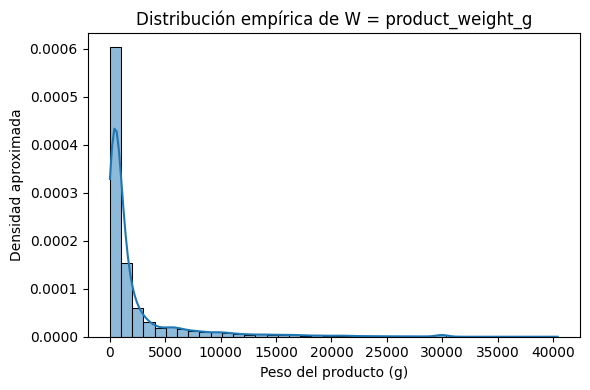


Comparación con recorte 1%-99% (solo diagnóstico, no reemplaza la definición clásica):
Media clásica : 2,276.75 g   |  Media recortada : 2,041.35 g
Std clásica   : 4,282.23 g |  Std recortada   : 3,464.79 g


In [ ]:
# 1) Seleccionar y limpiar la variable
W = products['product_weight_g'].dropna().astype(float)
W = W[W > 0]  # descartamos pesos no positivos si existen

n = W.shape[0]
print(f"n = {n:,}")

# 2) Estadísticos muestrales (ddof=1)
mean_w = W.mean()
var_w_sample = W.var(ddof=1)   # varianza muestral
std_w_sample = W.std(ddof=1)   # desviación muestral

# 3) (Referencia) Estadísticos poblacionales (ddof=0)
var_w_pop = W.var(ddof=0)
std_w_pop = W.std(ddof=0)

print(f"Media (≈ E[W])            : {mean_w:,.2f} g")
print(f"Varianza muestral (ddof=1): {var_w_sample:,.2f} g^2")
print(f"Desv. estándar muestral   : {std_w_sample:,.2f} g")
print(f"(Poblacional) Var ddof=0  : {var_w_pop:,.2f} g^2")
print(f"(Poblacional) Std ddof=0  : {std_w_pop:,.2f} g")

# 4) Verificación manual de s^2 = sum((w_i - w̄)^2)/(n-1)
var_manual = ((W - mean_w)**2).sum() / (n - 1)
print("\n¿Varianza manual coincide con pandas (muestral)?", np.isclose(var_manual, var_w_sample))

# 5) Muestra aleatoria: realizaciones de W
print("\n5 pesos tomados al azar (realizaciones de W):")
print(W.sample(5, replace=True, random_state=123).values)

# 6) Visualización rápida (distribución empírica)
plt.figure(figsize=(6,4))
sns.histplot(W, bins=40, stat='density', kde=True)
plt.xlabel("Peso del producto (g)")
plt.ylabel("Densidad aproximada")
plt.title("Distribución empírica de W = product_weight_g")
plt.tight_layout()
plt.show()

# 7) (Opcional) Comparar con una versión 'recortada' para ver sensibilidad a atípicos
W_trim = W[W.between(W.quantile(0.01), W.quantile(0.99))]
print("\nComparación con recorte 1%-99% (solo diagnóstico, no reemplaza la definición clásica):")
print(f"Media clásica : {mean_w:,.2f} g   |  Media recortada : {W_trim.mean():,.2f} g")
print(f"Std clásica   : {std_w_sample:,.2f} g |  Std recortada   : {W_trim.std(ddof=1):,.2f} g")


### **1.1.3 La Distribución de Probabilidad Normal (Gaussiana)**

# **1.1.3 La Distribución de Probabilidad Normal (Gaussiana)**

## Definición

Una variable aleatoria $X$ tiene distribución normal con media $\mu$ y varianza $\sigma^2$ si su función de densidad es:

$$
f(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right), \quad x \in \mathbb{R}.
$$

Se escribe $X \sim N(\mu, \sigma^2)$. Es simétrica alrededor de $\mu$, unimodal y presenta colas ligeras.

## Estimación de parámetros (MLE)

Dados datos $x_1, \dots, x_n$, los estimadores de máxima verosimilitud son:

$$
\hat{\mu} = \bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i, \quad \hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2.
$$

(En pandas, esto corresponde a `mean()` y `std(ddof=0)`.)

## Cuándo es razonable asumir Normalidad

- La variable es continua, aproximadamente simétrica y sin colas pesadas.
- El histograma y el QQ-plot se ajustan bien a una curva normal.
- Las pruebas de normalidad no rechazan la hipótesis (con cautela: con muestras muy grandes, pequeñas desviaciones darán p-valores muy pequeños).

## En datos reales (ej. pesos de productos)

`product_weight_g` suele ser asimétrica/mezcla por categorías; una transformación logarítmica puede acercar la forma a una normal: $Y = \log(W)$.

## Estrategia práctica de evaluación

- **Visual**: histograma + curva normal ajustada.
- **QQ-plot** (comparar cuantiles empíricos vs teóricos).
- **Pruebas de normalidad** (p. ej. D'Agostino $K^2$, Anderson–Darling) + skewness/kurtosis.
- Repetir sobre $\log(W)$ y comparar.

n = 32,945 observaciones
μ̂ (mean)  = 2,276.75 g
σ̂ (std)   = 4,282.16 g


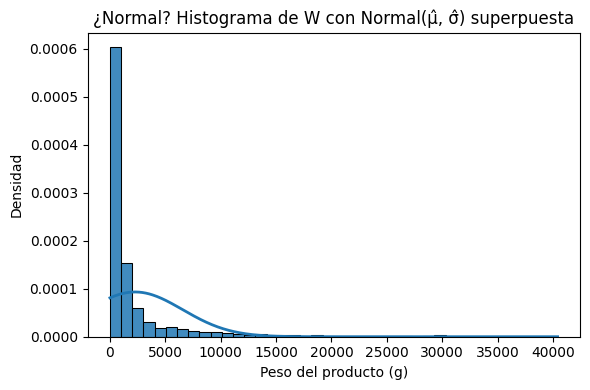

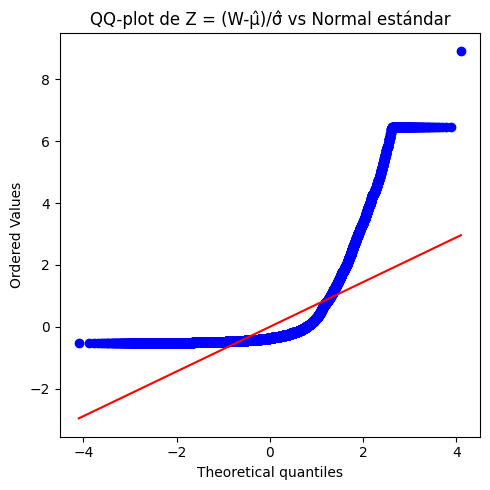


=== D’Agostino K^2 ===
Estadístico: 24,666.977 | p-valor: 0.000e+00 (H0: normalidad)

=== Momentos ===
Asimetría (skew): 3.605  (0 en Normal)
Curtosis (Fisher): 15.132  (0 en Normal)

=== Anderson–Darling ===
Estadístico A^2: 5,457.493
  Nivel 15%  →  crítico = 0.576  →  RECHAZA H0
  Nivel 10%  →  crítico = 0.656  →  RECHAZA H0
  Nivel 5%  →  crítico = 0.787  →  RECHAZA H0
  Nivel 2%  →  crítico = 0.918  →  RECHAZA H0
  Nivel 1%  →  crítico = 1.092  →  RECHAZA H0


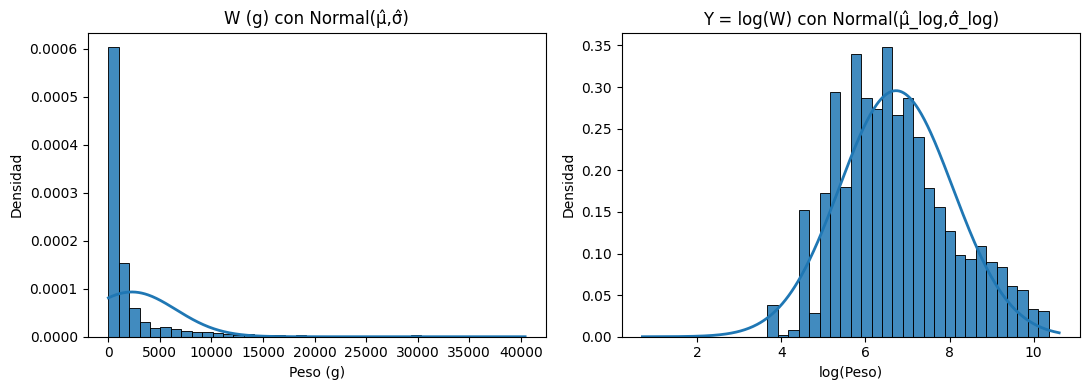

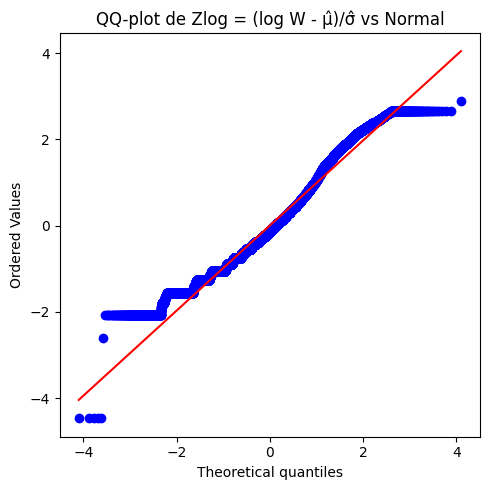


=== D’Agostino K^2 en log(W) ===
Estadístico: 1,241.511 | p-valor: 2.566e-270

Interpretación sugerida:
- Si el histograma y QQ-plot de W muestran cola derecha marcada y p-valor pequeño, la Normal NO es buen modelo para W.
- Si log(W) se ve más lineal en el QQ-plot y el ajuste visual mejora, un modelo log-normal puede ser más razonable.
- Con n muy grande, p-valores tienden a ser muy pequeños incluso por desviaciones leves; revisa también skew/kurtosis y los gráficos.


In [ ]:
# === 1) Preparación de los datos ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Tomamos la variable de interés: W = peso del producto (g)
W = products['product_weight_g'].dropna().astype(float)
W = W[W > 0]  # descartamos pesos no positivos si hubiera

n = W.shape[0]
print(f"n = {n:,} observaciones")

# === 2) Estimación de parámetros (MLE) para Normal ===
mu_hat = W.mean()
sigma_hat = W.std(ddof=0)  # ddof=0 para MLE poblacional
print(f"μ̂ (mean)  = {mu_hat:,.2f} g")
print(f"σ̂ (std)   = {sigma_hat:,.2f} g")

# === 3) Visual: Histograma + curva Normal ajustada ===
x = np.linspace(W.min(), W.max(), 400)
pdf = stats.norm.pdf(x, loc=mu_hat, scale=sigma_hat)

plt.figure(figsize=(6,4))
sns.histplot(W, bins=40, stat='density', alpha=0.85)
plt.plot(x, pdf, linewidth=2)
plt.xlabel("Peso del producto (g)")
plt.ylabel("Densidad")
plt.title("¿Normal? Histograma de W con Normal(μ̂, σ̂) superpuesta")
plt.tight_layout()
plt.show()

# === 4) QQ-plot (estandarizado) ===
Z = (W - mu_hat) / sigma_hat  # estandarizamos con MLE
plt.figure(figsize=(5,5))
stats.probplot(Z, dist="norm", plot=plt)
plt.title("QQ-plot de Z = (W-μ̂)/σ̂ vs Normal estándar")
plt.tight_layout()
plt.show()

# === 5) Pruebas de normalidad y momentos ===
# Con tamaños muy grandes, las pruebas tienden a rechazar normalidad por cualquier pequeña desviación.
# Reportamos también asimetría y curtosis para cuantificar el desvío.
k2_stat, k2_p = stats.normaltest(W, nan_policy='omit')  # D’Agostino K^2
skew = stats.skew(W, bias=False, nan_policy='omit')
kurt = stats.kurtosis(W, fisher=True, bias=False, nan_policy='omit')  # 0 sería normal
print("\n=== D’Agostino K^2 ===")
print(f"Estadístico: {k2_stat:,.3f} | p-valor: {k2_p:.3e} (H0: normalidad)")

print("\n=== Momentos ===")
print(f"Asimetría (skew): {skew:,.3f}  (0 en Normal)")
print(f"Curtosis (Fisher): {kurt:,.3f}  (0 en Normal)")

# Anderson–Darling (devuelve niveles críticos; no hay p-valor directo)
ad_res = stats.anderson(W, dist='norm')
print("\n=== Anderson–Darling ===")
print(f"Estadístico A^2: {ad_res.statistic:,.3f}")
for sl, cv in zip(ad_res.significance_level, ad_res.critical_values):
    print(f"  Nivel {sl:.0f}%  →  crítico = {cv:.3f}  →  {'RECHAZA H0' if ad_res.statistic > cv else 'NO rechaza H0'}")

# === 6) Diagnóstico alternativo: log-transformación ===
Y = np.log(W)  # log natural
mu_log = Y.mean()
sigma_log = Y.std(ddof=0)

# Visual en log
x_log = np.linspace(Y.min(), Y.max(), 400)
pdf_log = stats.norm.pdf(x_log, loc=mu_log, scale=sigma_log)

fig, axes = plt.subplots(1, 2, figsize=(11,4))
sns.histplot(W, bins=40, stat='density', ax=axes[0], alpha=0.85)
axes[0].plot(x, pdf, linewidth=2)
axes[0].set_title("W (g) con Normal(μ̂,σ̂)")
axes[0].set_xlabel("Peso (g)")
axes[0].set_ylabel("Densidad")

sns.histplot(Y, bins=40, stat='density', ax=axes[1], alpha=0.85)
axes[1].plot(x_log, pdf_log, linewidth=2)
axes[1].set_title("Y = log(W) con Normal(μ̂_log,σ̂_log)")
axes[1].set_xlabel("log(Peso)")
axes[1].set_ylabel("Densidad")

plt.tight_layout()
plt.show()

# QQ-plot en log
Zlog = (Y - mu_log) / sigma_log
plt.figure(figsize=(5,5))
stats.probplot(Zlog, dist="norm", plot=plt)
plt.title("QQ-plot de Zlog = (log W - μ̂)/σ̂ vs Normal")
plt.tight_layout()
plt.show()

# Prueba en log
k2_stat_log, k2_p_log = stats.normaltest(Y, nan_policy='omit')
print("\n=== D’Agostino K^2 en log(W) ===")
print(f"Estadístico: {k2_stat_log:,.3f} | p-valor: {k2_p_log:.3e}")

print("\nInterpretación sugerida:")
print("- Si el histograma y QQ-plot de W muestran cola derecha marcada y p-valor pequeño, la Normal NO es buen modelo para W.")
print("- Si log(W) se ve más lineal en el QQ-plot y el ajuste visual mejora, un modelo log-normal puede ser más razonable.")
print("- Con n muy grande, p-valores tienden a ser muy pequeños incluso por desviaciones leves; revisa también skew/kurtosis y los gráficos.")


#### **Intrepretación de los resultados:**


## **Resumen Estadístico**
- **Tamaño muestral**: n = 32,945 observaciones (muestra muy grande)
- **Media (μ̂)**: 2,276.75 g
- **Desviación estándar (σ̂)**: 4,282.16 g

## **Análisis de los Resultados**

### **1. Evidencia de No Normalidad en W**
- **Asimetría extrema**: 3.605 (muy superior a 0, esperado en normal)
  - Indica una distribución con cola derecha muy larga
- **Curtosis elevada**: 15.132 (mucho mayor que 3, esperado en normal)
  - Indica colas pesadas y pico más pronunciado
- **D'Agostino K²**: Estadístico enorme (24,666.977) con p-valor = 0.000
  - Rechazo contundente de la hipótesis nula de normalidad
- **Anderson-Darling**: Estadístico extremadamente alto (5,457.493)
  - Rechazo de H0 a todos los niveles de significancia (1%, 2%, 5%, 10%, 15%)

### **2. Interpretación Práctica**
- La distribución de pesos **no sigue una distribución normal**
- La alta asimetría positiva (3.605) sugiere:
  - Muchos productos con pesos relativamente bajos
  - Algunos productos con pesos excepcionalmente altos (valores atípicos)
- La desviación estándar (4,282.16 g) es casi el doble que la media (2,276.75 g), lo que confirma la alta dispersión y presencia de valores extremos

### **3. Transformación Logarítmica**
- **D'Agostino en log(W)**: Aunque mejoró (1,241.511 vs 24,666.977), el p-valor (2.566e-270) sigue indicando desviación significativa de la normalidad
- La transformación logarítmica **mejora pero no corrige completamente** la no normalidad

## **Conclusión**
La variable de peso de productos **no se distribuye normalmente** y presenta:
- **Asimetría extrema** hacia valores altos
- **Colas pesadas** con valores atípicos
- **Alta dispersión** relativa

**Recomendación**: Considerar análisis no paramétricos o modelar la distribución real (posiblemente mixture models) en lugar de asumir normalidad. La transformación logarítmica ayuda pero no es suficiente para alcanzar normalidad.


## **1.2 Relación entre Variables**

Para entender mejor la operación, analizaremos cómo se relacionan algunas de las variables más importantes en cualquier negocio de e-commerce o logística. Usaremos la covarianza y la correlación para responder a preguntas de negocio muy concretas.

1. Precio del Pedido vs. Costo del Flete (price ↔ freight_value)
Pregunta de negocio: ¿Los pedidos de mayor valor tienden a pagar un flete más caro? 🧐

Hipótesis: Podríamos suponer que sí. Pedidos con un price más elevado podrían estar asociados a un freight_value mayor por varias razones: un seguro de envío más costoso, un empaque más robusto, o simplemente porque los productos más caros tienden a ser más grandes o pesados. Analizaremos si existe una tendencia positiva entre estas dos variables.

2. Atributos Físicos del Producto vs. Costo del Flete (product_weight_g / product_volume_cm3 ↔ freight_value)
Pregunta de negocio: ¿El peso y el volumen de un producto impactan directamente en el costo de su envío? 📦

Hipótesis: Esta es la relación más fundamental en logística. Es casi seguro que a mayor peso (product_weight_g) o mayor volumen (calculado a partir de product_length_cm, product_height_cm, product_width_cm), el costo del flete (freight_value) será mayor. Las empresas de paquetería basan sus tarifas directamente en estas métricas. Nuestra meta será cuantificar qué tan fuerte y directa es esta relación.

In [ ]:
# Integrar items + products y crear variables útiles para 1.2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Merge mínimo a nivel de ítem: precio/flete + atributos del producto
ip = (items[['order_id','order_item_id','product_id','price','freight_value']]
      .merge(products[['product_id','product_weight_g','product_length_cm',
                       'product_height_cm','product_width_cm']],
             on='product_id', how='left'))

# Ensure relevant columns are numeric after merge
ip['price'] = pd.to_numeric(ip['price'], errors='coerce')
ip['freight_value'] = pd.to_numeric(ip['freight_value'], errors='coerce')
ip['product_weight_g'] = pd.to_numeric(ip['product_weight_g'], errors='coerce')
ip['product_length_cm'] = pd.to_numeric(ip['product_length_cm'], errors='coerce')
ip['product_height_cm'] = pd.to_numeric(ip['product_height_cm'], errors='coerce')
ip['product_width_cm'] = pd.to_numeric(ip['product_width_cm'], errors='coerce')


# Volume aproximado en cm^3 (caja mínima)
ip['product_volume_cm3'] = (ip['product_length_cm'] * ip['product_height_cm'] * ip['product_width_cm'])

# Limpieza básica (quitamos NA and valores no positivos/absurdos)
df_rel = ip.dropna(subset=['price','freight_value','product_weight_g','product_volume_cm3']).copy()
df_rel = df_rel[(df_rel['price']>0) & (df_rel['freight_value']>=0) &
                (df_rel['product_weight_g']>0) & (df_rel['product_volume_cm3']>0)]

# (Opcional) versión recortada al 1–99% para reducir atípicos extremos en gráficos/correls
numeric_cols = ['price','freight_value','product_weight_g','product_volume_cm3']
Q1 = df_rel[numeric_cols].quantile(0.01)
Q99 = df_rel[numeric_cols].quantile(0.99)
mask = (df_rel[numeric_cols] >= Q1) & (df_rel[numeric_cols] <= Q99)

df_trim = df_rel[mask.all(axis=1)].copy()

df_rel.shape, df_trim.shape

((112624, 10), (106634, 10))

### **1.2.1 Covarianza: ¿se mueven juntas?**

La **covarianza** entre dos variables $X$ e $Y$ mide cómo varían juntas:

$$
\operatorname{Cov}(X,Y) = \frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})
$$

### Signo

* **> 0**: Cuando $X$ está por encima de su media, $Y$ tiende a estar por encima de la suya (se mueven “en la misma dirección”).
* **< 0**: Tienden a moverse en direcciones opuestas.
* **≈ 0**: No hay una relación lineal clara (aunque podría existir una relación no lineal).

### Escala

La covarianza está en unidades combinadas (por ejemplo, “pesos × flete”), por lo que no es directamente comparable entre diferentes pares de variables con escalas distintas.

### Ejemplos en Logística/Mercado

* **X = `price`**, **Y = `freight_value`**: Si la covarianza es > 0, en promedio, los pedidos más caros también pagan un flete más alto.
* **X = `product_weight_g`**, **Y = `freight_value`**: Una covarianza positiva sugiere que los productos más pesados tienden a tener un flete más caro, lo cual es esperable debido a los costos de envío.

---

En resumen, la covarianza nos dice si las variables “se mueven juntas”, pero no qué tan fuerte es esa relación debido a su dependencia de la escala. Para medir la fuerza, utilizamos la **correlación**.

Covarianzas (sobre df_rel, sin recorte):
  price_vs_freight: 1,202.36
  weight_vs_freight: 36,202.79
  volume_vs_freight: 217,414.42


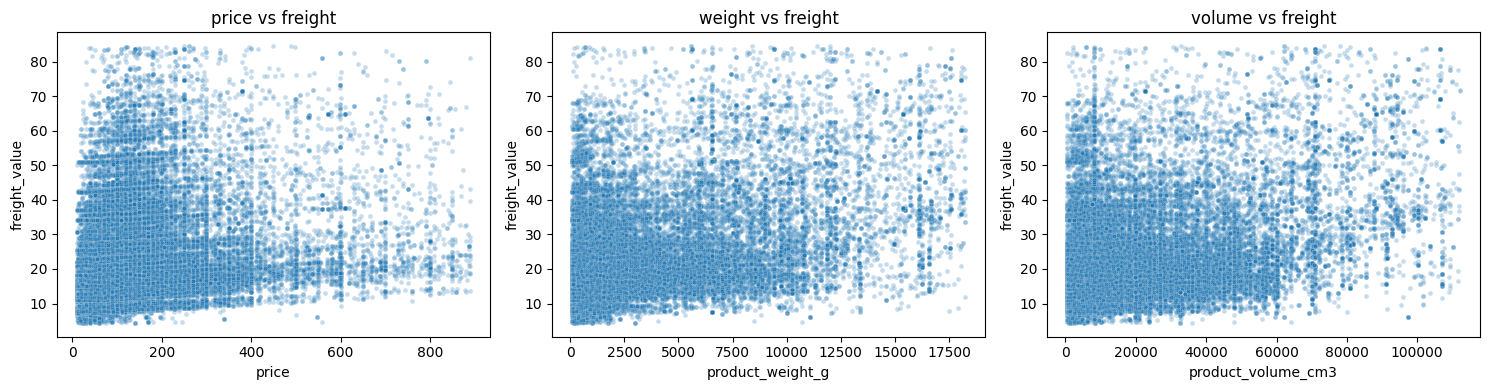

Matriz de Covarianza (sobre df_rel, sin recorte):
                           price  product_weight_g  product_volume_cm3  \
price               3.369883e+04      2.333490e+05        1.284388e+06   
product_weight_g    2.333490e+05      1.407517e+07        7.049077e+07   
product_volume_cm3  1.284388e+06      7.049077e+07        5.484625e+08   
freight_value       1.202361e+03      3.620279e+04        2.174144e+05   

                    freight_value  
price                 1202.360722  
product_weight_g     36202.786881  
product_volume_cm3  217414.417173  
freight_value          249.892731  


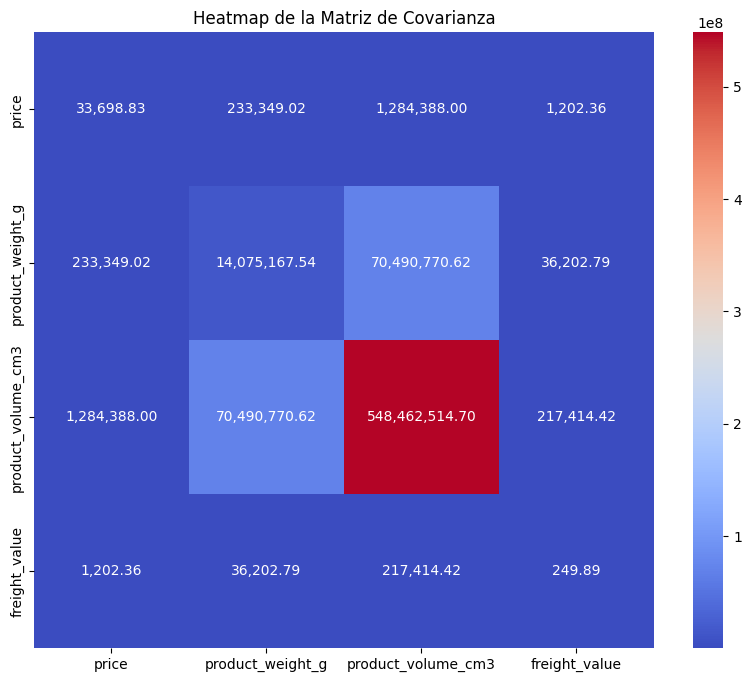

In [ ]:
pares = {
    'price_vs_freight': ('price','freight_value'),
    'weight_vs_freight': ('product_weight_g','freight_value'),
    'volume_vs_freight': ('product_volume_cm3','freight_value'),
}

# Covarianzas (muestrales)
covs = {k: df_rel[list(v)].cov().iloc[0,1] for k,v in pares.items()}
print("Covarianzas (sobre df_rel, sin recorte):")
for k, c in covs.items():
    print(f"  {k}: {c:,.2f}")

# Visual: dispersión para ver el “co-movimiento”
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, (k,(x,y)) in zip(axes, pares.items()):
    sns.scatterplot(data=df_trim, x=x, y=y, alpha=0.25, s=12, ax=ax)
    ax.set_title(k.replace('_',' '))
plt.tight_layout()
plt.show()



# --- 1. CÁLCULO Y VISUALIZACIÓN DE LA MATRIZ DE COVARIANZA ---

# Define las variables de interés para la matriz
variables_matriz = ['price', 'product_weight_g', 'product_volume_cm3', 'freight_value']



# Calcula la matriz de covarianza completa
# Usamos df_rel para que los valores coincidan con los que calculaste antes
cov_matrix = df_rel[variables_matriz].cov()

print("Matriz de Covarianza (sobre df_rel, sin recorte):")
print(cov_matrix)

# Visualización con un heatmap para que se vea "bonito"
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt=',.2f', cmap='coolwarm')
plt.title('Heatmap de la Matriz de Covarianza')
plt.show()


#### **Intrepretación de los resultados:**

**Signo: Todas las relaciones son positivas**

El hecho de que los tres valores de covarianza sean positivos (> 0) es el primer hallazgo importante. Esto confirma tus hipótesis iniciales:

*   price_vs_freight (1,202.36): A medida que el precio de un pedido sube, el costo del flete también tiende a subir. ✅

*   weight_vs_freight (36,202.79): A medida que el peso de un producto aumenta, el costo del flete también tiende a aumentar. ✅

*   volume_vs_freight (217,414.42): A medida que el volumen de un producto aumenta, el costo del flete también tiende a aumentar. ✅

En resumen, el signo nos dice que todas estas variables se mueven "en la misma dirección", lo cual tiene mucho sentido desde el punto de vista del negocio.

**Magnitud: ¡Cuidado con la escala! ⚠️**
Aquí viene la parte más importante y a menudo confusa. Podrías pensar que la relación volume_vs_freight es "más fuerte" que la de weight_vs_freight porque 217,414 es mucho más grande que 36,202. Esta conclusión es incorrecta.

*  El valor numérico (la magnitud) de la covarianza depende directamente de la escala de las variables que estás midiendo.

* El precio se mide en unidades monetarias (ej: 150.0).

* El peso se mide en gramos (ej: 3,000 g).

* El volumen se mide en cm³ (ej: 25,000 cm³).

Como los valores de volumen y peso son numéricamente mucho más grandes que los de precio, es natural que su covarianza con el flete también produzca un número mucho mayor.

**La conclusión clave:**

La covarianza no es útil para comparar la fuerza de la relación entre diferentes pares de variables. Solo te dice la dirección (positiva o negativa).

### **1.2.2 Correlación de Pearson (relaciones lineales)**



***

# Correlación de Pearson (Relaciones Lineales) 💡

### Definición

La **correlación de Pearson** es la covarianza estandarizada, lo que permite comparar la fuerza de la relación lineal entre diferentes pares de variables. Se define como:

$$\rho_{X,Y} = \frac{\operatorname{Cov}(X,Y)}{s_X s_Y}, \quad \rho \in [-1, 1]$$

Donde $s_X$ y $s_Y$ son las desviaciones estándar de las variables $X$ e $Y$.

***

### Interpretación

* **Magnitud**: El valor absoluto $|\rho|$ mide la **fuerza** de la relación lineal.
    * $|\rho| \approx 1$: Relación lineal casi perfecta.
    * $|\rho| \approx 0$: No hay relación lineal.

* **Signo**: Indica la **dirección** de la relación.
    * **Positivo (+)**: Ambas variables tienden a aumentar o disminuir juntas.
    * **Negativo (-)**: Cuando una variable aumenta, la otra tiende a disminuir.

* **Invarianza de escala**: A diferencia de la covarianza, la correlación no tiene unidades. Esto significa que puedes comparar directamente si la relación `peso-flete` es más fuerte que la de `precio-flete`.

* **Sensibilidad a atípicos**: El coeficiente de Pearson es sensible a valores extremos (outliers). Si sospechas que los outliers están afectando el resultado, es útil comparar la correlación sobre datos recortados o usar alternativas como la correlación de Spearman.

***

### Lectura de Negocio en Logística

* $\rho(\text{price}, \text{freight\_value}) > 0$: Indica que, de manera lineal, los pedidos más caros tienden a tener un flete mayor.
* $\rho(\text{product\_weight\_g}, \text{freight\_value}) > 0$: Confirma la relación esperada: a más peso, más costo de flete.
* $\rho(\text{product\_volume\_cm3}, \text{freight\_value}) > 0$: Mide qué tan fuerte es la relación entre el volumen cúbico y el flete. Esto es clave para entender si las tarifas se basan más en el peso real o en el peso dimensional (volumétrico).

Correlaciones de Pearson con freight_value (df_rel sin recorte):
  r(price,freight_value) =  0.414 | p=0.0e+00
  r(product_weight_g,freight_value) =  0.610 | p=0.0e+00
  r(product_volume_cm3,freight_value) =  0.587 | p=0.0e+00

Correlaciones de Pearson (df_trim recortado 1–99%):
  r(price,freight_value) =  0.337 | p=0.0e+00
  r(product_weight_g,freight_value) =  0.504 | p=0.0e+00
  r(product_volume_cm3,freight_value) =  0.426 | p=0.0e+00


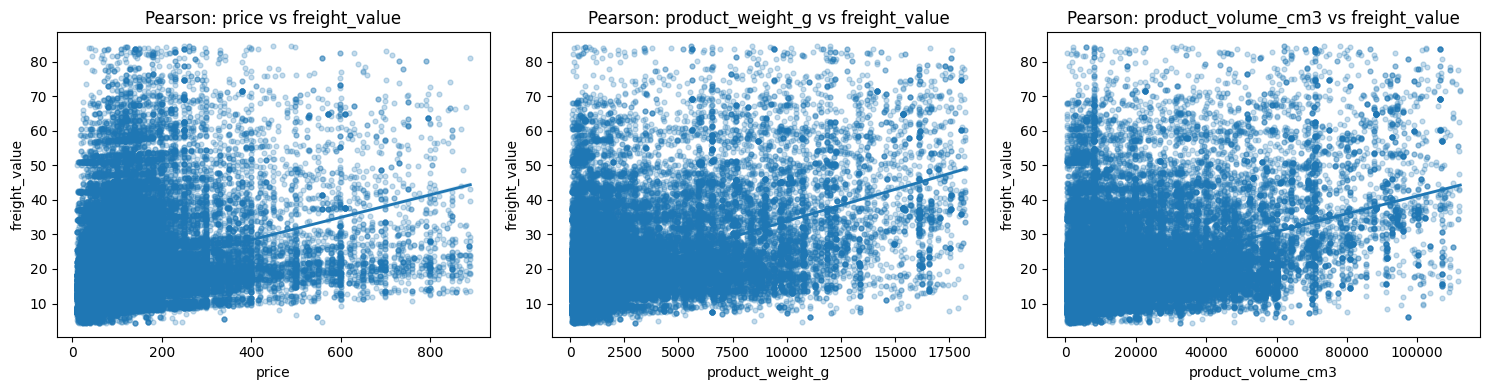

In [ ]:
targets = ['price','product_weight_g','product_volume_cm3']
y = 'freight_value'

print("Correlaciones de Pearson con freight_value (df_rel sin recorte):")
for x in targets:
    r, p = stats.pearsonr(df_rel[x], df_rel[y])
    print(f"  r({x},{y}) = {r: .3f} | p={p:.1e}")

print("\nCorrelaciones de Pearson (df_trim recortado 1–99%):")
for x in targets:
    r, p = stats.pearsonr(df_trim[x], df_trim[y])
    print(f"  r({x},{y}) = {r: .3f} | p={p:.1e}")

# Dispersión + recta de tendencia (lineal) en la muestra recortada
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, x in zip(axes, targets):
    sns.regplot(data=df_trim, x=x, y=y, scatter_kws={'alpha':0.25, 's':12}, line_kws={'lw':2}, ax=ax)
    ax.set_title(f"Pearson: {x} vs {y}")
plt.tight_layout()
plt.show()

#### **Intrepretación de los resultados:**
En resumen, los resultados muestran que las **características físicas (peso y volumen) tienen una correlación positiva moderada-fuerte con el costo del flete**, mientras que el precio tiene una correlación más débil. Además, la presencia de valores atípicos está inflando ligeramente la fuerza de estas relaciones.

---

1. Interpretación General (Datos `df_rel` sin recorte) 📊

Primero, analicemos el **p-valor**, que es `p=0.0e+00` (es decir, cero) para todos los casos.

* **Significancia Estadística:** Un p-valor tan bajo significa que los resultados son **extremadamente significativos**. Puedes estar muy seguro de que las correlaciones que observas no son producto del azar.

Ahora, interpretemos los coeficientes de correlación (`r`):

* **`r(product_weight_g, freight_value) = 0.610`**: Esta es la **correlación más fuerte**. Un valor de 0.61 indica una **relación lineal positiva y moderada-fuerte**. A medida que el peso del producto aumenta, el costo del flete tiende a aumentar de manera bastante predecible.
* **`r(product_volume_cm3, freight_value) = 0.587`**: Es una correlación casi tan fuerte como la del peso. Indica una **relación lineal positiva y moderada**. El volumen también es un excelente predictor del costo del flete.
* **`r(price, freight_value) = 0.414`**: Esta es una **relación lineal positiva, pero más débil** que las anteriores. Si bien los productos más caros tienden a tener fletes más caros, la relación no es tan directa o fuerte como con el peso o el volumen.

---

2. El Efecto de los Outliers (Comparando `df_rel` vs. `df_trim`) 📉

Aquí está la parte más interesante. Al recortar los valores extremos (outliers) del 1% superior e inferior, **todas las correlaciones disminuyeron**.

* `weight`: bajó de 0.610 a **0.504**
* `volume`: bajó de 0.587 a **0.426**
* `price`: bajó de 0.414 a **0.337**

**¿Qué significa esto?**

Significa que los **valores atípicos estaban "inflando" o fortaleciendo la correlación lineal**. Por ejemplo, unos pocos productos extremadamente pesados y con fletes extremadamente caros hacían que la línea de tendencia pareciera más fuerte de lo que es para la gran mayoría de los datos.

Los valores del `df_trim` (el dataset recortado) son probablemente una **representación más honesta y robusta** de la relación para el 98% de tus pedidos "normales".

---

### 3. Conclusiones de Negocio 🚚

1.  **El Peso es el Rey:** El **peso del producto es el predictor lineal más fuerte** del costo de envío, seguido muy de cerca por el volumen. Esto confirma que las tarifas de flete están fuertemente ligadas a las características físicas del producto.
2.  **El Precio es Secundario:** El precio tiene una relación positiva, pero es un factor menos directo. El flete no se calcula por el precio, pero quizás productos más caros tienden a ser más pesados o voluminosos, explicando esta correlación más débil.
3.  **Cuidado con los Extremos:** Tu análisis muestra que los casos extremos (productos muy pesados/caros) siguen la misma tendencia, pero de forma tan marcada que sesgan ligeramente la medición general. Para predecir el costo de flete de un producto promedio, los coeficientes del `df_trim` son más fiables.

### **1.2.3 Correlación de Spearman (relaciones monótonas)**


***

## Correlación de Spearman ($\rho_s$) para Relaciones Monótonas 📈

### Definición

La **correlación de Spearman ($\rho_s$)** es el coeficiente de correlación de Pearson aplicado sobre los **rangos** (las posiciones ordenadas) de las variables $X$ e $Y$.

Su principal ventaja es que captura relaciones **monótonas** (consistentemente crecientes o decrecientes), incluso si estas no son lineales.

---

### Cuándo Usarla

Es la mejor opción en los siguientes escenarios:

* **Hay no linealidades evidentes**: La relación entre las variables sigue una dirección, pero no en línea recta. Un ejemplo clásico son los saltos en tarifas de flete que aumentan por tramos de peso o volumen.
* **Existen valores atípicos (outliers)**: Como Spearman trabaja con el orden de los datos y no con sus valores directos, es mucho menos sensible a valores extremos que puedan distorsionar la correlación de Pearson.
* **La hipótesis es general**: Esperas que "a más de X, haya más de Y", pero no te importa si esa relación es perfectamente lineal.

---

### Lectura en Logística

* Si $\rho_s(\text{volume}, \text{freight}) > \rho(\text{volume}, \text{freight})$, es una fuerte señal de que el costo del flete crece con el volumen, pero probablemente lo hace por **tramos o escalones** (una relación monótona, pero no estrictamente lineal).
* Es muy útil para validar hipótesis sobre **reglas de negocio**, como el impacto de las bandas tarifarias basadas en peso o volumen.

Comparación Pearson vs Spearman (df_trim):
  price ~ freight_value: Pearson r= 0.337 (p=0.0e+00) | Spearman ρ= 0.402 (p=0.0e+00)
  product_weight_g ~ freight_value: Pearson r= 0.504 (p=0.0e+00) | Spearman ρ= 0.422 (p=0.0e+00)
  product_volume_cm3 ~ freight_value: Pearson r= 0.426 (p=0.0e+00) | Spearman ρ= 0.337 (p=0.0e+00)


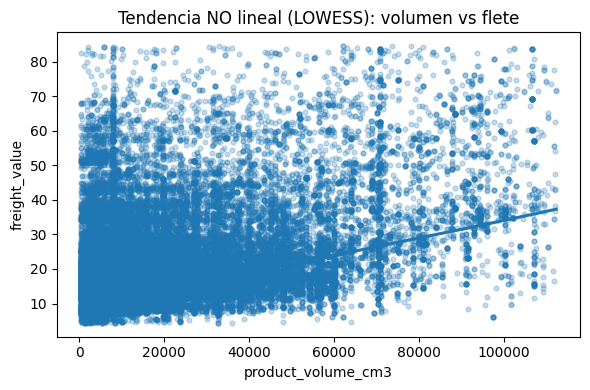

In [ ]:
targets = ['price','product_weight_g','product_volume_cm3']
y = 'freight_value'

print("Comparación Pearson vs Spearman (df_trim):")
for x in targets:
    r_p, p_p = stats.pearsonr(df_trim[x], df_trim[y])
    r_s, p_s = stats.spearmanr(df_trim[x], df_trim[y])
    print(f"  {x} ~ {y}: Pearson r={r_p: .3f} (p={p_p:.1e}) | Spearman ρ={r_s: .3f} (p={p_s:.1e})")

# Visual: tendencia no lineal suave (LOWESS) para un caso típico: volumen vs flete
plt.figure(figsize=(6,4))
sns.regplot(data=df_trim, x='product_volume_cm3', y='freight_value',
            lowess=True, scatter_kws={'alpha':0.25, 's':12})
plt.title("Tendencia NO lineal (LOWESS): volumen vs flete")
plt.tight_layout()
plt.show()




#### **Interpretación: Pearson vs. Spearman**

Todos los resultados son **estadísticamente significativos** (p-valor ≈ 0), por lo que las relaciones son reales. La diferencia entre Pearson y Spearman nos revela la *forma* de esa relación.

* **Precio vs. Flete** 💲
    * **Resultado Clave:** La relación es **más consistente que lineal** (Spearman > Pearson).
    * **En simple:** A medida que el precio sube, el flete también sube de forma predecible, pero no necesariamente en una línea recta perfecta. Puede haber saltos o tramos.

* **Peso vs. Flete** ⚖️
    * **Resultado Clave:** La relación es **predominantemente lineal** (Pearson > Spearman).
    * **En simple:** El costo del flete aumenta de manera muy directa y proporcional al peso. Es la relación más fuerte y mejor descrita por una línea recta.

* **Volumen vs. Flete** 📦
    * **Resultado Clave:** La relación también es **principalmente lineal** (Pearson > Spearman).
    * **En simple:** Al igual que con el peso, el flete aumenta de forma bastante constante y directa a medida que el volumen crece.

## **1.3 De la Muestra a la Población**


### **1.3.1 Conceptos: Muestreo e Inferencia Estadística**

#### 1.3.1 Muestreo e Inferencia: ideas clave

* **Población**: conjunto de todos los posibles valores de una variable (p. ej., tiempos de entrega de una PyME).
* **Muestra**: subconjunto de la población que observamos (tamaño $n$).
* **Parámetro**: número fijo de la población (p. ej., la media $\mu$). **No lo conocemos**.
* **Estadístico**: número calculado con la muestra (p. ej., $\bar x$). **Lo observamos**.
* **Estimación**: usar el estadístico para aproximar el parámetro ($\bar x \approx \mu$).
* **Distribución muestral**: si repites el muestreo muchas veces, los valores del estadístico cambian; esa variación forma una distribución (la “variabilidad del estimador”).
* **Error estándar (SE)**: dispersión de la distribución muestral. Para la media:

  $$
  \text{SE}(\bar X) \approx \frac{s}{\sqrt{n}}.
  $$
* **Inferencia**: sacar conclusiones sobre la población (parámetros) a partir de la muestra, cuantificando la **incertidumbre** (SE, intervalos de confianza, pruebas).

**Intuición logística/mercado**: si calculas el **promedio de días de entrega** con $n=30$ órdenes, te puede salir 7.9 días; si vuelves a tomar otro $n=30$, quizá 8.4. No cambió la empresa: cambió **la muestra**. La **distribución muestral** explica esa variación.

---

μ (población, desconocido en la vida real): 8.37  |  σ: 4.47

Muestra n=50:
- Media muestral (x̄): 7.83
- Desv. muestral (s):  3.76
- Error estándar (≈ s/√n): 0.53

Distribución muestral (simulada) de x̄ con n=50:
- Media de x̄: 8.40 (≈ μ)
- Desv. de x̄: 0.64 (≈ SE)


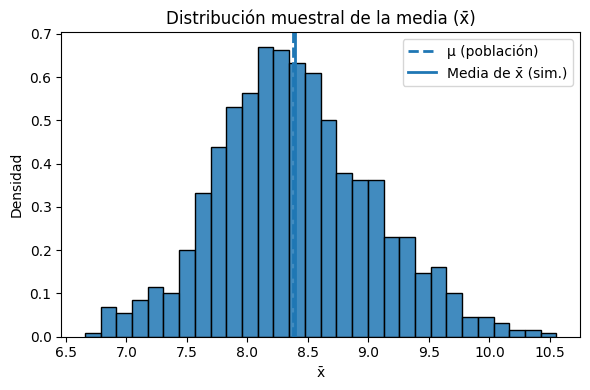

In [ ]:

rng = np.random.default_rng(42)

# Población sintética: "tiempos de entrega" sesgados (log-normal en días)
N = 1_000_000
pop = rng.lognormal(mean=2.0, sigma=0.5, size=N)  # media aprox e^{2 + 0.5^2/2}

mu_pop = pop.mean()
sd_pop = pop.std(ddof=0)
print(f"μ (población, desconocido en la vida real): {mu_pop:,.2f}  |  σ: {sd_pop:,.2f}")

# Una muestra
n = 50
sample = rng.choice(pop, size=n, replace=False)
xbar = sample.mean()
s = sample.std(ddof=1)
se_est = s/np.sqrt(n)

print(f"\nMuestra n={n}:")
print(f"- Media muestral (x̄): {xbar:,.2f}")
print(f"- Desv. muestral (s):  {s:,.2f}")
print(f"- Error estándar (≈ s/√n): {se_est:,.2f}")

# Variabilidad del estimador: repetir muestreo muchas veces
R = 1000
means = np.array([rng.choice(pop, size=n, replace=False).mean() for _ in range(R)])

print(f"\nDistribución muestral (simulada) de x̄ con n={n}:")
print(f"- Media de x̄: {means.mean():,.2f} (≈ μ)")
print(f"- Desv. de x̄: {means.std(ddof=1):,.2f} (≈ SE)")

plt.figure(figsize=(6,4))
sns.histplot(means, bins=30, stat='density', alpha=0.85)
plt.axvline(mu_pop, linestyle='--', linewidth=2, label='μ (población)')
plt.axvline(means.mean(), linestyle='-', linewidth=2, label='Media de x̄ (sim.)')
plt.title("Distribución muestral de la media (x̄)")
plt.xlabel("x̄")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()


### **1.3.2 Teorema del Límite Central (simulación práctica)**


El **TLC** dice que, para muchas distribuciones de partida (aunque sean sesgadas), cuando el tamaño de muestra $n$ es suficientemente grande, la **media muestral** $\bar X$ se distribuye **aproximadamente Normal**:

$$
\bar X \approx \mathcal{N}\!\left(\mu, \frac{\sigma^2}{n}\right).
$$

**Consecuencias prácticas**:

* Podemos usar herramientas normales (intervalos, pruebas) **aunque los datos originales no sean normales**, si $n$ es moderado/grande.
* Al crecer $n$, la **variabilidad** de $\bar X$ se reduce como $1/\sqrt{n}$.

**Qué vamos a ver**: para una población sesgada (log-normal), simulamos muchas medias muestrales $\bar X$ con distintos $n$ y observamos que la forma se vuelve **más normal** y **más concentrada**.

---


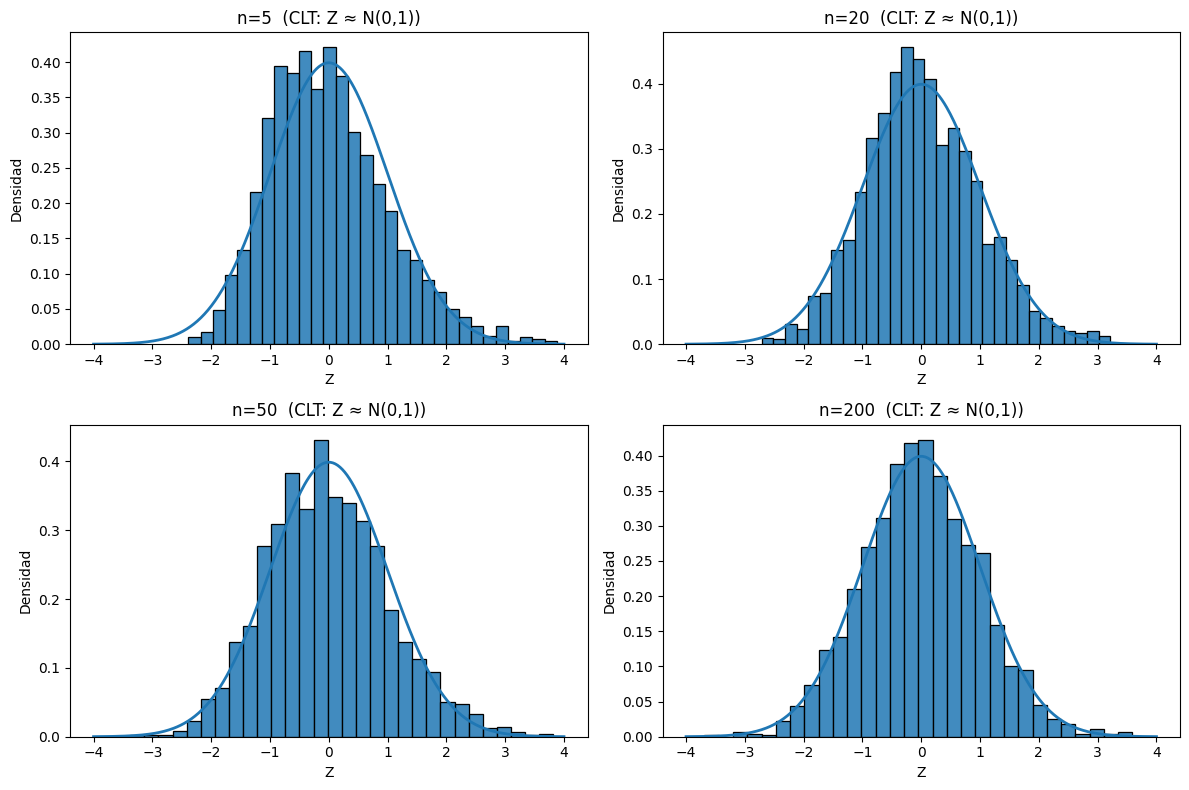

In [ ]:
from scipy import stats

rng = np.random.default_rng(123)

# Usamos la población sesgada creada antes (pop, mu_pop, sd_pop)
n_list = [5, 20, 50, 200]
R = 2000

fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.ravel()

for ax, n in zip(axes, n_list):
    means = np.array([rng.choice(pop, size=n, replace=False).mean() for _ in range(R)])

    # Estandarizamos: Z = (x̄ - μ) / (σ/√n) debería parecerse a N(0,1)
    Z = (means - mu_pop) / (sd_pop/np.sqrt(n))

    sns.histplot(Z, bins=30, stat='density', alpha=0.85, ax=ax)
    x = np.linspace(-4,4,400)
    ax.plot(x, stats.norm.pdf(x), linewidth=2)
    ax.set_title(f"n={n}  (CLT: Z ≈ N(0,1))")
    ax.set_xlabel("Z")
    ax.set_ylabel("Densidad")

plt.tight_layout()
plt.show()


### **1.3.3 Bootstrapping: simulando distribuciones muestrales sin teoría**


**Problema**: no conocemos la **distribución muestral** de un estadístico (media, mediana, percentil, etc.), o la fórmula del SE es complicada/inexistente.

**Idea del bootstrap** (Efron):

1. Tienes **una sola muestra observada** $x = \{x_1,\dots,x_n\}$.
2. Generas $B$ **remuestras** de tamaño $n$ **con reemplazo** desde $x$: $x^{*b}$.
3. Calculas el estadístico en cada remuestra: $\theta^{*b}=t(x^{*b})$.
4. La **distribución bootstrap** de $\theta^{*}$ **aproxima** la distribución muestral de $\hat\theta=t(x)$.
5. Un **IC del 95%** por percentiles es $[\theta^{*}_{2.5\%}, \theta^{*}_{97.5\%}]$.

**Cuándo usarlo**:

* Para **mediana**, **percentiles**, **correlaciones**, **métricas no lineales**.
* Cuando el tamaño $n$ no es enorme pero suficiente (regla de dedo: $n\gtrsim 30$ y datos representativos).
* Cuando desconfías de supuestos paramétricos (normalidad, linealidad, etc.).

---


Datos observados (n=80)
- Media    (θ̂): 8.55
- Mediana  (θ̂): 6.90

Intervalos de confianza (Bootstrap percentil, 95%)
- Media   : [7.37, 9.81]
- Mediana : [6.13, 7.78]


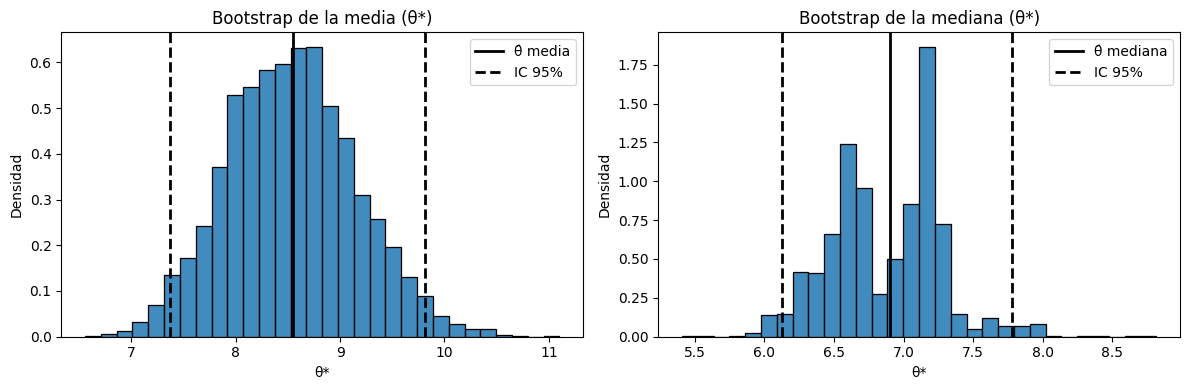


Interpretación:
- La distribución bootstrap aproxima cómo habría variado el estimador si hubiéramos repetido el muestreo real.
- El IC percentil toma directamente los percentiles 2.5% y 97.5% de esa distribución simulada.
- La mediana suele tener distribución muestral menos 'normal' que la media; el bootstrap es especialmente útil allí.


In [ ]:

rng = np.random.default_rng(2025)

# 1) "Datos observados": simulamos que esta muestra es todo lo que tenemos
n = 80
data = rng.choice(pop, size=n, replace=False)  # en la práctica: tus datos reales
theta_hat_mean = data.mean()
theta_hat_median = np.median(data)

print(f"Datos observados (n={n})")
print(f"- Media    (θ̂): {theta_hat_mean:,.2f}")
print(f"- Mediana  (θ̂): {theta_hat_median:,.2f}")

# 2) Bootstrap por remuestreo con reemplazo
B = 3000
boot_means   = np.empty(B)
boot_medians = np.empty(B)

for b in range(B):
    sample_b = rng.choice(data, size=n, replace=True)
    boot_means[b]   = sample_b.mean()
    boot_medians[b] = np.median(sample_b)

# 3) ICs percentil 95%
ci_mean = np.percentile(boot_means, [2.5, 97.5])
ci_median = np.percentile(boot_medians, [2.5, 97.5])

print("\nIntervalos de confianza (Bootstrap percentil, 95%)")
print(f"- Media   : [{ci_mean[0]:.2f}, {ci_mean[1]:.2f}]")
print(f"- Mediana : [{ci_median[0]:.2f}, {ci_median[1]:.2f}]")

# 4) Visualización de las distribuciones bootstrap
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(boot_means, bins=30, stat='density', alpha=0.85, ax=axes[0])
axes[0].axvline(theta_hat_mean, color='k', linestyle='-', linewidth=2, label='θ̂ media')
axes[0].axvline(ci_mean[0], color='k', linestyle='--', linewidth=2, label='IC 95%')
axes[0].axvline(ci_mean[1], color='k', linestyle='--', linewidth=2)
axes[0].set_title("Bootstrap de la media (θ*)")
axes[0].set_xlabel("θ*")
axes[0].set_ylabel("Densidad")
axes[0].legend()

sns.histplot(boot_medians, bins=30, stat='density', alpha=0.85, ax=axes[1])
axes[1].axvline(theta_hat_median, color='k', linestyle='-', linewidth=2, label='θ̂ mediana')
axes[1].axvline(ci_median[0], color='k', linestyle='--', linewidth=2, label='IC 95%')
axes[1].axvline(ci_median[1], color='k', linestyle='--', linewidth=2)
axes[1].set_title("Bootstrap de la mediana (θ*)")
axes[1].set_xlabel("θ*")
axes[1].set_ylabel("Densidad")
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nInterpretación:")
print("- La distribución bootstrap aproxima cómo habría variado el estimador si hubiéramos repetido el muestreo real.")
print("- El IC percentil toma directamente los percentiles 2.5% y 97.5% de esa distribución simulada.")
print("- La mediana suele tener distribución muestral menos 'normal' que la media; el bootstrap es especialmente útil allí.")

## **1.4 Validación de Supuestos**

**Objetivo.** Evaluar una afirmación sobre un **parámetro poblacional** (p. ej., la media $\mu$) con evidencia de una muestra.

### **1.4.1 Test de Hipótesis: el framework científico**


**Objetivo.** Evaluar una afirmación sobre un **parámetro poblacional** (p. ej., la media $\mu$) con evidencia de una muestra.

**Términos clave (con significado):**

* **Población**: todos los posibles casos (p. ej., todos los tiempos de entrega futuros de la PyME).
* **Parámetro**: número fijo de la población (p. ej., $\mu=$ media verdadera de días de entrega). **No lo conocemos**.
* **Muestra**: datos observados (p. ej., $n=50$ pedidos recientes).
* **Estadístico**: número calculado con la muestra (p. ej., $\bar x=$ media muestral). **Sí lo conocemos**.
* **Hipótesis nula** $H_0$: punto de comparación/base (p. ej., $\mu=8$ días).
* **Hipótesis alternativa** $H_1$: lo que queremos evidenciar (p. ej., $\mu>8$ si sospechamos retrasos).
* **Nivel de significancia** $\alpha$: tolerancia máxima a **falsos positivos** (error Tipo I). Típico $\alpha=0.05$.
* **Estadístico de prueba**: transforma los datos para medir cuán compatibles son con $H_0$ (p. ej., estadístico t).
* **Regla de decisión**: si el **p-valor $\le \alpha$** → **rechazar $H_0$**; si no → **no rechazar $H_0$**.

n=50  x̄=8.36  s=4.31
t=0.593  |  p(cola derecha)=0.2778  |  α=0.05
IC 95% para μ: [7.14, 9.59]
Cohen's d (vs μ0): 0.08
Decisión: NO rechazar H0


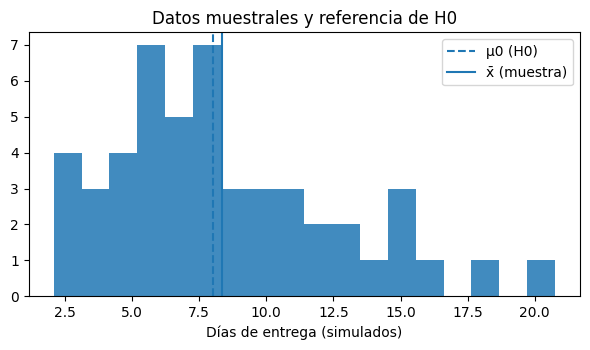


Cómo leer esto:
- Si p ≤ α, decimos que hay evidencia estadística para un aumento (μ > 8).
- El IC 95% muestra el rango plausible de μ; si todo el IC > 8, refuerza la conclusión.
- Cohen's d sugiere magnitud del cambio en 'desv. estándar muestral'.


In [ ]:
# Test t de 1 muestra, H0: mu = 8 vs H1: mu > 8 (cola derecha)


rng = np.random.default_rng(2025)

# Población sintética: "días de entrega" sesgados (log-normal)
pop = rng.lognormal(mean=2.0, sigma=0.5, size=1_000_000)

mu0 = 8.0     # valor propuesto por H0
alpha = 0.05  # tolerancia a falsos positivos
n = 50        # tamaño de muestra (típico en control operativo)

# 1) "Recolectamos" muestra
x = rng.choice(pop, size=n, replace=False)
xbar = x.mean()
s = x.std(ddof=1)

# 2) Estadístico t y p-valor (cola derecha)
t_stat = (xbar - mu0) / (s / np.sqrt(n))
p_right = 1 - stats.t.cdf(t_stat, df=n-1)

# 3) Intervalo de confianza 95% para la media
ci_low, ci_high = stats.t.interval(confidence=0.95, df=n-1, loc=xbar, scale=s/np.sqrt(n))

# 4) Tamaño de efecto (Cohen's d) relativo a mu0
cohen_d = (xbar - mu0) / s

print(f"n={n}  x̄={xbar:.2f}  s={s:.2f}")
print(f"t={t_stat:.3f}  |  p(cola derecha)={p_right:.4f}  |  α={alpha}")
print(f"IC 95% para μ: [{ci_low:.2f}, {ci_high:.2f}]")
print(f"Cohen's d (vs μ0): {cohen_d:.2f}")

decision = "RECHAZAR H0" if p_right <= alpha else "NO rechazar H0"
print(f"Decisión: {decision}")

# 5) Visual: comparación de la media muestral con μ0
plt.figure(figsize=(6,3.6))
plt.hist(x, bins=18, alpha=0.85)
plt.axvline(mu0, ls='--', label='μ0 (H0)')
plt.axvline(xbar, ls='-', label='x̄ (muestra)')
plt.title("Datos muestrales y referencia de H0")
plt.xlabel("Días de entrega (simulados)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Interpretación práctica ---
print("\nCómo leer esto:")
print("- Si p ≤ α, decimos que hay evidencia estadística para un aumento (μ > 8).")
print("- El IC 95% muestra el rango plausible de μ; si todo el IC > 8, refuerza la conclusión.")
print("- Cohen's d sugiere magnitud del cambio en 'desv. estándar muestral'.")


#### **Intrepretación de los resultados:**

En resumen, aunque el promedio de tu muestra (8.36) es un poco más alto que 8, **no tienes evidencia estadística suficiente para afirmar que ha habido un aumento real**. La pequeña diferencia que observaste se debe muy probablemente al azar.

---

### El Veredicto en Simple 🧐

Imagina que quieres saber si los estudiantes de un colegio ahora son más altos que el promedio histórico de 1.60 m. Tomas una muestra y te da un promedio de 1.61 m. La pregunta clave es: *¿Ese centímetro extra es una tendencia real o simplemente tuviste la suerte de medir a algunos de los estudiantes más altos?*

Tu análisis estadístico responde a esta pregunta:

* **Tu resultado (`x̄=8.36`):** Es un poco mayor que 8.
* **La conclusión (`No rechazar H0`):** No puedes concluir que el promedio real sea mayor que 8. La diferencia es tan pequeña que se considera "ruido estadístico" o una simple casualidad de la muestra que tomaste.

---

### Desglose de los Resultados

Aquí te explico qué significa cada pieza de tu análisis, como pediste:

#### 1. El p-valor (`p = 0.2778`)

* **Qué es:** Es la probabilidad de obtener un resultado como el tuyo (o más extremo) si en realidad no hubiera ningún cambio (es decir, si el promedio real siguiera siendo 8).
* **Tu resultado:** Tu p-valor es de `0.2778`, o un **27.8%**.
* **Interpretación sencilla:** Hay una probabilidad de casi el 28% de que obtengas una media de 8.36 solo por pura casualidad, aunque el promedio real no haya subido de 8. Como esta probabilidad es muy alta (mucho mayor que tu umbral del 5% o `α=0.05`), no puedes considerar tu hallazgo como una evidencia sólida. Es un resultado muy común y no indica un cambio real.

> **Regla clave:** Si `p ≤ α`, el resultado es significativo. En tu caso, `0.2778 > 0.05`, por lo que no es significativo.

#### 2. El Intervalo de Confianza (IC 95% para μ: `[7.14, 9.59]`)

* **Qué es:** Es el rango de valores donde tienes un 95% de confianza de que se encuentra el *verdadero promedio* de toda la población.
* **Tu resultado:** Tu rango va de 7.14 a 9.59.
* **Interpretación sencilla:** El verdadero promedio podría ser tan bajo como 7.14 o tan alto como 9.59. Como el número **8 está incluido en este rango**, es totalmente plausible que el promedio real siga siendo 8. Si realmente hubiera un aumento, todo el intervalo debería estar por encima de 8 (por ejemplo, `[8.1, 9.8]`).

#### 3. La d de Cohen (`d = 0.08`)

* **Qué es:** Mide el **tamaño o la magnitud del efecto** que observaste, sin importar si es estadísticamente significativo. Mide qué tan grande es la diferencia en términos de desviaciones estándar.
* **Tu resultado:** `0.08`.
* **Interpretación sencilla:** Esto indica que la diferencia entre tu media muestral (8.36) y el valor de referencia (8) es de apenas 0.08 desviaciones estándar. Es un **efecto minúsculo o insignificante**. Incluso si tuvieras una muestra gigante y el resultado fuera "estadísticamente significativo", la d de Cohen te diría que el cambio es tan pequeño que en la práctica no tiene ninguna importancia.

### **1.4.2 Significancia Estadística (p-valor)**

* **Definición.** El **p-valor** es la **probabilidad**, **asumiendo que $H_0$ es verdadera**, de obtener un resultado **tan extremo o más** que el observado.

  * Ej.: si $H_0$ dice $\mu=8$ y vemos $\bar x=9.1$, el p-valor es la probabilidad (bajo $\mu=8$) de ver $\bar X\ge 9.1$ por puro azar.
* **Regla de decisión.** Si $p \le \alpha$, **rechazamos $H_0$** (resultado “estadísticamente significativo”).
* **Lo que NO es.** No es “la probabilidad de que $H_0$ sea verdadera/falsa”, ni “la magnitud del efecto”.
* **Cuidado con el tamaño muestral.** Con $n$ enorme, pequeñas diferencias se vuelven “significativas” (p muy chico) sin relevancia práctica. Por eso se reporta también **tamaño de efecto** e **IC**.

**Hecho importante.** Si $H_0$ fuese cierta y repitiésemos el experimento innumerables veces, alrededor de un $\alpha$% de los p-valores caerían por debajo de $\alpha$ **por azar** (falsos positivos).


Bajo H0: proporción de p ≤ 0.05: 0.056  (≈ α esperado)
Bajo H1: proporción de p ≤ 0.05: 0.562  (≈ potencia)


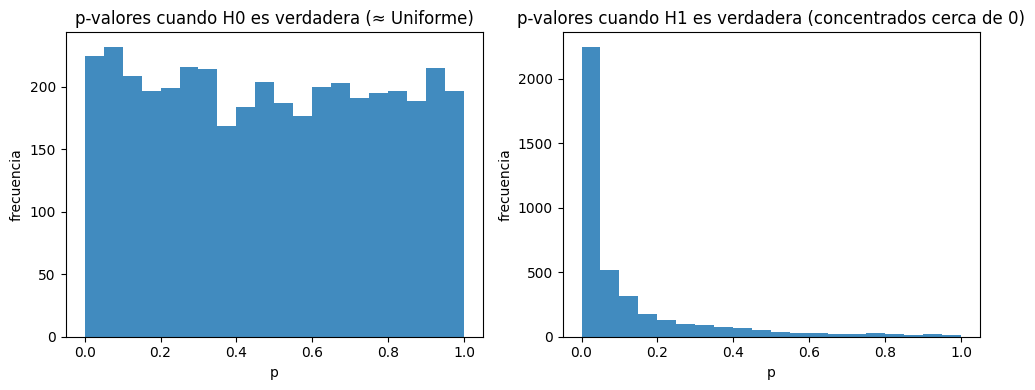


Lectura:
- Cuando H0 es cierta, ≈α de las veces p≤α (falsos positivos esperados).
- Cuando H1 es cierta, muchos p caen cerca de 0 (mayor potencia).


In [ ]:
# Distribución de p-valores cuando H0 es verdadera vs cuando H1 es verdadera


rng = np.random.default_rng(7)
alpha = 0.05
R = 4000
n = 30

# H0 verdadera: mu=0
pvals_H0 = []
for _ in range(R):
    x = rng.normal(loc=0, scale=1, size=n)
    t_stat, p_two = stats.ttest_1samp(x, popmean=0.0)  # prueba de 2 colas
    pvals_H0.append(p_two)

# H1 verdadera: mu=delta (>0)
delta = 0.4  # tamaño de efecto pequeño-moderado
pvals_H1 = []
for _ in range(R):
    x = rng.normal(loc=delta, scale=1, size=n)
    t_stat, p_two = stats.ttest_1samp(x, popmean=0.0)
    pvals_H1.append(p_two)

pvals_H0 = np.array(pvals_H0)
pvals_H1 = np.array(pvals_H1)

print(f"Bajo H0: proporción de p ≤ {alpha}: {(pvals_H0 <= alpha).mean():.3f}  (≈ α esperado)")
print(f"Bajo H1: proporción de p ≤ {alpha}: {(pvals_H1 <= alpha).mean():.3f}  (≈ potencia)")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(pvals_H0, bins=20, range=(0,1), alpha=0.85)
plt.title("p-valores cuando H0 es verdadera (≈ Uniforme)")
plt.xlabel("p"); plt.ylabel("frecuencia")

plt.subplot(1,2,2)
plt.hist(pvals_H1, bins=20, range=(0,1), alpha=0.85)
plt.title("p-valores cuando H1 es verdadera (concentrados cerca de 0)")
plt.xlabel("p"); plt.ylabel("frecuencia")

plt.tight_layout()
plt.show()

print("\nLectura:")
print("- Cuando H0 es cierta, ≈α de las veces p≤α (falsos positivos esperados).")
print("- Cuando H1 es cierta, muchos p caen cerca de 0 (mayor potencia).")


#### **La Analogía del Detector de Humo 💨**

Los resultados muestran que tu prueba estadística está bien configurada para evitar conclusiones falsas cuando no pasa nada (**controla bien los falsos positivos**), pero es relativamente débil para encontrar un efecto real cuando sí existe (**tiene una potencia modesta**).



Imagina que tu prueba estadística es un detector de humo.

* **No hay fuego ($H₀$ es cierta):** La situación normal.
* **Sí hay fuego ($H₁$ es cierta):** Existe un peligro real que se debe detectar.
* **La alarma suena ($p \le 0.05$):** Concluyes que hay un efecto (o un fuego).

Ahora, veamos tus dos escenarios.

***

### 1. Cuando NO hay un efecto real (Bajo $H₀$)
> `proporción de p ≤ 0.05: 0.056`

Esto es como probar tu detector de humo quemando una tostada. Idealmente, no debería sonar, pero a veces lo hace.

* **Lo que significa:** Si repitieras tu experimento muchas veces en una situación donde **no hay ningún efecto real**, aproximadamente el **5.6%** de las veces, por pura casualidad, tu prueba haría sonar la alarma y te haría creer erróneamente que encontraste algo importante.
* **Tu lectura es correcta:** Este `5.6%` es la tasa de **falsos positivos** (Error de Tipo I). Está muy cerca de tu nivel de significancia `α=0.05`, lo que indica que la prueba se comporta como esperas. Estás dispuesto a aceptar un 5% de "falsas alarmas", y eso es lo que obtienes.

***

### 2. Cuando SÍ hay un efecto real (Bajo $H₁$)
> `proporción de p ≤ 0.05: 0.562`

Esto es como probar tu detector con un fuego de verdad. Quieres que la alarma suene siempre.

* **Lo que significa:** Cuando **sí existe un efecto real** que se puede descubrir, tu prueba tiene una **capacidad del 56.2% para detectarlo** y hacer sonar la alarma correctamente.
* **Tu lectura es correcta:** Este `56.2%` es la **potencia estadística** de tu prueba. Es la probabilidad de tener un **verdadero positivo**.

### Conclusión Práctica 🎯

* **El lado bueno:** Puedes confiar en que tu prueba no te dará falsas alarmas a menudo. Está bien calibrada para ser cautelosa.
* **El lado malo:** Con una potencia del 56.2%, tu prueba no es muy sensible. Esto significa que tienes una probabilidad considerable (**43.8%**) de **no detectar un efecto aunque sea real** (esto se conoce como un falso negativo o Error de Tipo II). En la analogía, sería un fuego real que tu detector no logra percibir.

Generalmente, en investigación se busca una potencia del 80% (`0.80`) o más. Un valor de `0.562` se considera bajo, lo que sugiere que tu estudio podría necesitar una muestra más grande u otro ajuste para tener una mejor oportunidad de encontrar lo que buscas.

### **1.4.3 Error Tipo I y Error Tipo II: los dos tipos de equivocaciones**

* **Error Tipo I (α)**: Rechazar $H_0$ **siendo verdadera** (falso positivo). $\alpha$ es la probabilidad de cometer este error **por diseño** (p. ej., 5%).
* **Error Tipo II (β)**: **No** rechazar $H_0$ **siendo falsa** (falso negativo).
* **Potencia** $=1-β$: Probabilidad de **detectar** un efecto real (es decir, rechazar $H_0$ cuando $H_1$ es cierta).

**Cómo aumentar la potencia (disminuir β):**

* **Más muestra** $n$ (reduce el error estándar).
* **Menos ruido** (mejor medición, segmentar por categorías homogéneas).
* **Mayor efecto** (si el cambio real es más grande, se detecta más fácil).
* **Prueba adecuada** y (cuando es justificable) **unilateral** si la dirección del efecto es clara.

**Trade-off**: bajar $\alpha$ reduce falsos positivos, pero **baja potencia** si todo lo demás queda igual (aumenta β).

**Ejemplo logístico.** Si realmente la media es $\mu=8.5$ (peor que 8), pero tu $n$ es pequeño y/o hay mucho ruido, puedes **no detectarlo** (error Tipo II). Planear $n$ suficiente es clave.


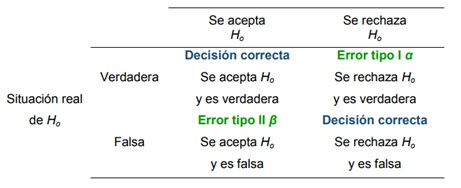


n=30, delta=0.5:  Tipo I≈0.049  |  Tipo II≈0.254  |  Potencia≈0.746


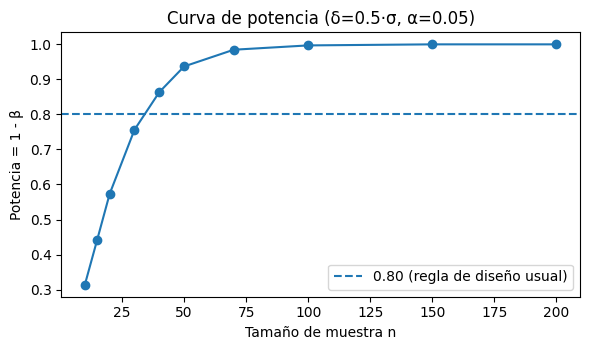


Lectura:
- Tipo I se acerca a α (controlado por diseño).
- La potencia crece con n y con el tamaño del efecto δ.
- Para lograr potencia ≥0.80 con δ dado, necesitas un n mínimo (planificación de muestras).


In [ ]:
# Simulación de tasas de Error Tipo I, Tipo II y Potencia (prueba t de 1 muestra, 2 colas)


rng = np.random.default_rng(123)
alpha = 0.05
R = 3000

def sim_rates(n, delta, sigma=1.0):
    # H0: mu=0 ; H1 verdadera: mu=delta
    # Devuelve: (Tipo I, Tipo II, Potencia)
    # Tipo I: cuando H0 es verdadera
    pvals_H0 = []
    for _ in range(R):
        x = rng.normal(loc=0.0, scale=sigma, size=n)
        t, p = stats.ttest_1samp(x, popmean=0.0)  # dos colas
        pvals_H0.append(p)
    typeI = (np.array(pvals_H0) <= alpha).mean()

    # Potencia: cuando H1 es verdadera
    pvals_H1 = []
    for _ in range(R):
        x = rng.normal(loc=delta, scale=sigma, size=n)
        t, p = stats.ttest_1samp(x, popmean=0.0)
        pvals_H1.append(p)
    power = (np.array(pvals_H1) <= alpha).mean()
    typeII = 1 - power
    return typeI, typeII, power

# 1) Un punto de trabajo
n = 30
delta = 0.5  # efecto real en unidades de desviación estándar
typeI, typeII, power = sim_rates(n=n, delta=delta)
print(f"n={n}, delta={delta}:  Tipo I≈{typeI:.3f}  |  Tipo II≈{typeII:.3f}  |  Potencia≈{power:.3f}")

# 2) Curva de potencia vs n (diseño muestral)
n_grid = [10, 15, 20, 30, 40, 50, 70, 100, 150, 200]
powers = []
for n in n_grid:
    _, _, pw = sim_rates(n=n, delta=delta)
    powers.append(pw)

plt.figure(figsize=(6,3.6))
plt.plot(n_grid, powers, marker='o')
plt.axhline(0.80, ls='--', label='0.80 (regla de diseño usual)')
plt.title(f"Curva de potencia (δ={delta}·σ, α={alpha})")
plt.xlabel("Tamaño de muestra n")
plt.ylabel("Potencia = 1 - β")
plt.legend()
plt.tight_layout()
plt.show()

print("\nLectura:")
print("- Tipo I se acerca a α (controlado por diseño).")
print("- La potencia crece con n y con el tamaño del efecto δ.")
print("- Para lograr potencia ≥0.80 con δ dado, necesitas un n mínimo (planificación de muestras).")


#### **Intrepretación de los resultados:**

Piensa en tu prueba estadística como un detective que intenta resolver un caso. El "efecto" (una diferencia o relación real) es el culpable. 🕵️

## Error de Tipo I (≈0.049)

Esta es la probabilidad de que el detective **acuse a una persona inocente**. Tu tasa es de aproximadamente **4.9%**, lo que está muy cerca del límite estándar del 5% (`α=0.05`). Esto significa que tu "detective" está bien calibrado y rara vez hace acusaciones falsas. Este es tu **riesgo de un falso positivo**.

***

## Potencia (≈0.746)

Esta es la probabilidad de que el detective **atrape al verdadero culpable** cuando este realmente ha cometido el crimen. Tu potencia es de aproximadamente **74.6%**. Esto significa que si existe un efecto real del tamaño `δ=0.5`, tu experimento tiene una probabilidad de ~75% de encontrarlo. Esta es tu **tasa de un verdadero positivo**.

***

## Error de Tipo II (≈0.254)

Esta es la probabilidad de que el detective **deje escapar al culpable**. Tu tasa es de aproximadamente **25.4%**. Es la otra cara de la potencia (`1 - 0.746`). Hay una probabilidad de ~25% de que tu experimento no detecte el efecto, a pesar de que sea real. Este es tu **riesgo de un falso negativo**.

***

## En Resumen

Tu experimento tiene un **bajo riesgo de "llorar lobo"** (acusar a un inocente), pero una **posibilidad moderada de no ver al lobo real**.

El objetivo común es tener una potencia de al menos el 80% (`≥0.80`). Tu resultado (`74.6%`) está cerca, pero no llega a esa meta. Como tus notas señalan correctamente, para aumentar la potencia y mejorar tus posibilidades de encontrar el efecto, necesitarías **aumentar el tamaño de tu muestra (`n`)**.

#  **Sección 2: Introducción a la Optimización Lineal**


La **optimización lineal**, también conocida como programación lineal, es una técnica matemática que se utiliza para encontrar el mejor resultado posible (como el máximo beneficio o el costo más bajo) en un modelo cuyos requisitos se representan mediante relaciones lineales.

Consiste en maximizar o minimizar una función lineal, sujeta a un conjunto de restricciones también lineales.

***

### Formulación Matemática

El objetivo de un problema de optimización lineal se puede expresar matemáticamente de la siguiente forma:

#### **1. Función Objetivo**
Es la ecuación que se desea maximizar o minimizar.

$$\text{Maximizar o Minimizar } Z = c_1x_1 + c_2x_2 + \dots + c_nx_n$$

Donde:
* **$Z$** es el valor a optimizar (ej. beneficio, costo).
* **$x_1, x_2, \dots, x_n$** son las **variables de decisión** (ej. cantidad de productos a fabricar).
* **$c_1, c_2, \dots, c_n$** son los coeficientes de la función objetivo (ej. el precio o costo de cada producto).

#### **2. Restricciones**
Son las limitaciones o condiciones que deben cumplirse, expresadas como inecuaciones o ecuaciones lineales.

$$
\begin{align*}
a_{11}x_1 + a_{12}x_2 + \dots + a_{1n}x_n & \le b_1 \\
a_{21}x_1 + a_{22}x_2 + \dots + a_{2n}x_n & \le b_2 \\
\vdots \qquad & \vdots \\
a_{m1}x_1 + a_{m2}x_2 + \dots + a_{mn}x_n & \le b_m
\end{align*}
$$

Donde:
* **$a_{ij}$** son los coeficientes técnicos que indican cómo cada variable consume un recurso.
* **$b_i$** representa la cantidad disponible de cada recurso (ej. horas de mano de obra, kilos de materia prima).
* El símbolo de la inecuación puede ser `≤`, `≥` o `=`.

#### **3. Restricción de no negatividad**
Las variables de decisión generalmente no pueden tomar valores negativos.

$$x_1, x_2, \dots, x_n \ge 0$$

## **2.1 Programación de personal con optimización lineal**

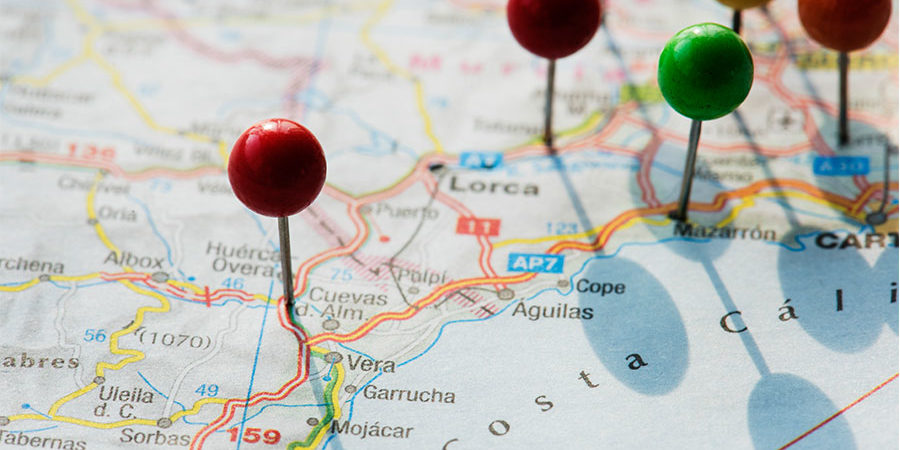


# Programación de Personal (5x2) con Optimización Lineal (MILP)

**Enunciado.**  
Un restaurante atiende al público los siete días de la semana. Se contratan camareros que trabajan **seis horas diarias**. El contrato con el sindicato estipula que **cada camarero trabaja cinco días consecutivos y descansa dos** (ciclo 5×2). Todos reciben el mismo salario.  

Las **horas mínimas requeridas** por día son:

| Día | Horas mínimas |
|---|---:|
| Lunes | 150 |
| Martes | 200 |
| Miércoles | 400 |
| Jueves | 300 |
| Viernes | 700 |
| Sábado | 800 |
| Domingo | 300 |

Se desea encontrar un **programa de empleo** que satisfaga estos requerimientos con **costo mínimo** (equivalente a **minimizar la cantidad total de camareros**, ya que todos ganan lo mismo).

> Resolveremos el problema con **Optimización Lineal Entera** paso a paso y validaremos la solución.


In [ ]:
# Días (códigos sin tildes para variables) y nombres bonitos para mostrar
day_codes = ["Lun","Mar","Mie","Jue","Vie","Sab","Dom"]
day_names = {
    "Lun": "Lunes",
    "Mar": "Martes",
    "Mie": "Miércoles",
    "Jue": "Jueves",
    "Vie": "Viernes",
    "Sab": "Sábado",
    "Dom": "Domingo",
}

# Horas mínimas requeridas por día (del enunciado)
hours_req = {
    "Lun": 150,
    "Mar": 200,
    "Mie": 400,
    "Jue": 300,
    "Vie": 700,
    "Sab": 800,
    "Dom": 300,
}

H = 6  # horas que aporta un camarero por día (6 h/día)

import pandas as pd
df_hours = pd.DataFrame(
    {"Día": [day_names[d] for d in day_codes],
     "Horas mínimas": [hours_req[d] for d in day_codes]}
)
df_hours


,Día,Horas mínimas
0,Lunes,150
1,Martes,200
2,Miércoles,400
3,Jueves,300
4,Viernes,700
5,Sábado,800
6,Domingo,300


#### Restricción de Personal Mínimo por Día

Para asegurar que se cubra la demanda mínima de horas cada día, se establece la siguiente restricción.

Primero, definimos la **cantidad mínima de camareros necesarios** para un día $t$, denotada como $N_t$:

$$N_t = \left\lceil \frac{H_t}{6} \right\rceil$$

Donde:
* $H_t$ es el total de **horas mínimas requeridas** en el día $t$.
* El operador $\lceil \cdot \rceil$ es la **función techo**, que redondea el resultado hacia el entero superior más cercano.

A continuación, definimos una **variable de decisión binaria** $x_{i,t}$ para cada camarero $i$ y cada día $t$:

$$x_{i,t} = \begin{cases} 1 & \text{si el camarero } i \text{ trabaja el día } t \\ 0 & \text{en caso contrario} \end{cases}$$

La restricción final exige que la suma de los camareros que trabajan en un día específico sea, como mínimo, la cantidad necesaria $N_t$. Esto se formula de la siguiente manera:

$$\sum_{i \in C} x_{i,t} \geq N_t \quad \forall t \in D$$

Donde:
* $C$ es el conjunto de todos los camareros disponibles.
* $D$ es el conjunto de todos los días del período de planificación.
* El símbolo $\forall$ significa "para todo", indicando que esta restricción debe cumplirse para cada uno de los días.


In [ ]:
import math
N = {d: math.ceil(hours_req[d] / H) for d in day_codes}

df_people = pd.DataFrame(
    {"Día": [day_names[d] for d in day_codes],
     "Personas requeridas N_t": [N[d] for d in day_codes]}
)
df_people


,Día,Personas requeridas N_t
0,Lunes,25
1,Martes,34
2,Miércoles,67
3,Jueves,50
4,Viernes,117
5,Sábado,134
6,Domingo,50


### ¿Cómo funciona este modelo en términos simples?

Imagina que en lugar de contratar camareros individuales, estás formando **7 equipos**, uno por cada día de la semana.

* El **"Equipo del Lunes"** (`x_Lunes`) es el grupo de personas que siempre empieza su semana laboral de 5 días el lunes.
* El **"Equipo del Martes"** (`x_Martes`) es el que siempre empieza el martes, y así sucesivamente.

Tu modelo responde a dos preguntas fundamentales:

1.  **Decisión Principal:** ¿Qué **tamaño** debe tener cada uno de estos 7 equipos (`x_Lunes`, `x_Martes`, ..., `x_Domingo`)?

2.  **Objetivo:** ¿Cómo hacemos que estos equipos sean lo más pequeños posible en total (`min Σ x_d`) para no contratar a más gente de la necesaria?

---

### La Clave: Las Restricciones de Cobertura

La parte más importante es asegurarte de que cada día tengas suficientes manos trabajando. Tu ecuación de restricciones hace exactamente esto:

$$\sum_{d} a_{td}\,x_d \;\ge\; N_t$$

Veámoslo con un ejemplo para un día concreto, digamos el **miércoles** (`t` = Miércoles):

* **Pregunta:** ¿Quiénes están trabajando el miércoles?
* **Respuesta:** Todos los equipos cuyo bloque de 5 días incluye el miércoles. Estos son los equipos que empezaron a trabajar el:
    * Sábado (trabajan S-D-L-M-**Mi**)
    * Domingo (trabajan D-L-M-**Mi**-J)
    * Lunes (trabajan L-M-**Mi**-J-V)
    * Martes (trabajan M-**Mi**-J-V-S)
    * Miércoles (trabajan **Mi**-J-V-S-D)

Los equipos que empezaron el jueves o el viernes están descansando el miércoles.

Por lo tanto, la restricción para el miércoles se convierte en:

$$x_{\text{Sábado}} + x_{\text{Domingo}} + x_{\text{Lunes}} + x_{\text{Martes}} + x_{\text{Miércoles}} \ge N_{\text{Miércoles}}$$

El modelo simplemente construye una de estas ecuaciones para **cada día de la semana** y luego busca los valores de $x_d$ más pequeños que cumplan las 7 ecuaciones simultáneamente. Es una forma muy elegante y computacionalmente efectiva de resolver este problema.


In [ ]:
def coverage_matrix_5x2(day_codes):
    n = len(day_codes)
    A = np.zeros((n, n), dtype=int)
    # Para cada columna j (inicio del bloque), marcamos 5 días trabajados
    for j in range(n):
        for k in range(5):
            A[(j + k) % n, j] = 1
    return A

A = coverage_matrix_5x2(day_codes)
dfA = pd.DataFrame(A, index=[day_names[d] for d in day_codes],
                   columns=[f"x_{d}" for d in day_codes])
dfA


,x_Lun,x_Mar,x_Mie,x_Jue,x_Vie,x_Sab,x_Dom
Lunes,1,0,0,1,1,1,1
Martes,1,1,0,0,1,1,1
Miércoles,1,1,1,0,0,1,1
Jueves,1,1,1,1,0,0,1
Viernes,1,1,1,1,1,0,0
Sábado,0,1,1,1,1,1,0
Domingo,0,0,1,1,1,1,1


In [ ]:
!pip -q install pulp -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 86.8 MB/s eta 0:00:00


In [ ]:
import pulp as pl

# Creamos el modelo
m = pl.LpProblem("Staffing_5on2off", pl.LpMinimize)

# Variables enteras x_d >= 0
x = pl.LpVariable.dicts("x", day_codes, lowBound=0, cat=pl.LpInteger)

# Función objetivo: minimizar total de camareros
m += pl.lpSum(x[d] for d in day_codes)

# Restricciones de cobertura: A x >= N
for i, day in enumerate(day_codes):
    m += pl.lpSum(A[i, j] * x[day_codes[j]] for j in range(len(day_codes))) >= N[day], f"cover_{day}"

# Resolver (CBC por defecto)
m.solve(pl.PULP_CBC_CMD(msg=False))

status = pl.LpStatus[m.status]
sol = {d: int(pl.value(x[d])) for d in day_codes}
W = sum(sol.values())

print("Estado:", status)
print("\n--- Asignación óptima (personas que INICIAN su bloque ese día) ---")
for d in day_codes:
    print(f"{day_names[d]}: {sol[d]}")
print("\nTotal de camareros (W):", W)


Estado: Optimal

--- Asignación óptima (personas que INICIAN su bloque ese día) ---
Lunes: 0
Martes: 34
Miércoles: 33
Jueves: 67
Viernes: 0
Sábado: 0
Domingo: 0

Total de camareros (W): 134


In [ ]:
# Cobertura lograda por día
cover = {day_codes[i]: int(sum(A[i, j]*sol[day_codes[j]] for j in range(len(day_codes))))
         for i in range(len(day_codes))}

df_res = pd.DataFrame({
    "Requerido N_t": [N[d] for d in day_codes],
    "Logrado": [cover[d] for d in day_codes],
    "Slack = Logrado - N_t": [cover[d]-N[d] for d in day_codes],
}, index=["Lun","Mar","Mie","Jue","Vie","Sab","Dom"])
df_res


,Requerido N_t,Logrado,Slack = Logrado - N_t
Lun,25,67,42
Mar,34,34,0
Mie,67,67,0
Jue,50,134,84
Vie,117,134,17
Sab,134,134,0
Dom,50,100,50


### ¿Cómo leer la solución?

Sí, tu interpretación es completamente correcta y muy clara. Resume perfectamente cómo funciona el modelo, qué significan las variables y cómo usar los resultados en la práctica.

Aquí tienes la información organizada y formateada en Markdown, incluyendo una tabla de verificación que calcula la cobertura real para cada día según tu solución óptima.

***

## Resultados de la Optimización

El modelo encontró una solución óptima para minimizar el personal total necesario.

* **Estado de la Solución:** Óptima ✅

### Función Objetivo (Costo Mínimo)

El número total mínimo de camareros necesarios para cumplir con todas las restricciones es:

* **Total de Camareros (Z): 134**

---

### Asignación Óptima por Día de Inicio

Esta es la decisión clave del modelo: cuántas personas deben **iniciar** su bloque de trabajo de 5 días en cada día de la semana.

* **Lunes:** 0 personas
* **Martes:** 34 personas
* **Miércoles:** 33 personas
* **Jueves:** 67 personas
* **Viernes:** 0 personas
* **Sábado:** 0 personas
* **Domingo:** 0 personas

---

## Verificación de la Cobertura Diaria

Esta tabla demuestra **cómo la asignación anterior logra cubrir el personal necesario cada día**. La "Cobertura Lograda" es el número total de personas trabajando en un día específico, y este valor siempre debe ser mayor o igual al mínimo requerido para ese día ($N_t$).

| Día de la Semana | Equipos que Trabajan ese Día (por su día de inicio) | **Cobertura Lograda (Camareros Presentes)** |
| :--------------- | :---------------------------------------------------- | :----------------------------------------- |
| **Lunes** | Jueves, Viernes, Sábado, Domingo, Lunes               | $67+0+0+0+0 = \textbf{67}$                 |
| **Martes** | Viernes, Sábado, Domingo, Lunes, Martes               | $0+0+0+0+34 = \textbf{34}$                  |
| **Miércoles** | Sábado, Domingo, Lunes, Martes, Miércoles             | $0+0+0+34+33 = \textbf{67}$                 |
| **Jueves** | Domingo, Lunes, Martes, Miércoles, Jueves             | $0+0+34+33+67 = \textbf{134}$                |
| **Viernes** | Lunes, Martes, Miércoles, Jueves, Viernes             | $0+34+33+67+0 = \textbf{134}$                |
| **Sábado** | Martes, Miércoles, Jueves, Viernes, Sábado             | $34+33+67+0+0 = \textbf{134}$                |
| **Domingo** | Miércoles, Jueves, Viernes, Sábado, Domingo            | $33+67+0+0+0 = \textbf{100}$                |

Esta solución es **óptima** porque utiliza el mínimo absoluto de personal (134 personas) para garantizar que la cobertura de cada día cumpla o supere los requisitos mínimos ($N_t$).
